# hadron-Ar_XS

This ipython notebook is a tutorial for the hadron-Ar cross-section measurement using slicing method.

## Part 0. Import python packages and define physical quantities

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy import stats, integrate
from time import time
from iminuit import Minuit,cost
import ROOT
import pickle

### constants
NA = 6.02214076e23 # Avogadro constant (mol^{-1})

### probe particle (e.g. pi+)
m_probe = 139.57 # mass (MeV)

### target material (e.g. liquid argon)
rho_tar = 1.4 # density (g/cm^3)
M_tar = 39.95 # molar mass (g/mol)
n_tar = rho_tar*NA/M_tar # number density (cm^{-3})

### plot settings
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'legend.fontsize': 14})
plt.rcParams['font.family'] = 'times'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.minor.size'] = 3

Welcome to JupyROOT 6.28/04


## Part 1. Event simulation
Generate probe-material scattering events according to user-defined cross-sections. The material is not a thin-target, but it is filled in a large tank. The probe will be detected as a track in the material. Each event has three properties, the initial kinetic energy of the track, the kinetic energy at the end of the track, and a flag indicating what type of interaction it is between probe and material.

### User-defined cross-section curves (unit: mb)
`_tot`: total XS; `_ex`: signal exclusive XS; `_oth`: other exclusive XS
So we have `XS_tot == XS_ex + XS_oth`
Caveat: need to make sure `XS_tot`, `XS_ex`, `XS_oth` are all positive.

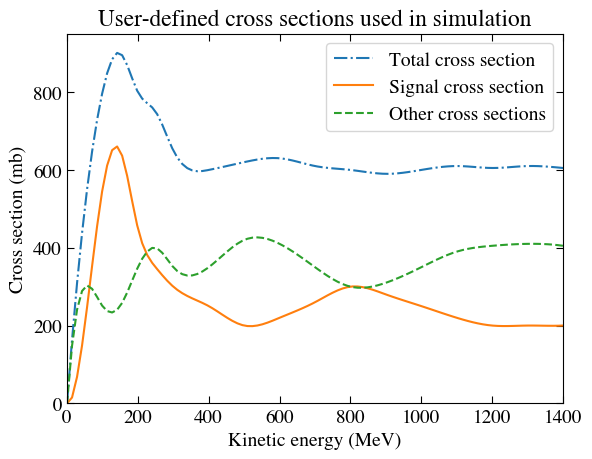

In [2]:
usr_define_xs_curve_method = 2
if usr_define_xs_curve_method == 1: # use polynomial to define cross-section curves
    XS_gen_tot = np.poly1d([-2.689e-20, 1.880e-16, -5.497e-13, 8.701e-10, -8.047e-7, 4.358e-4, -1.298e-1, 1.783e1, 0])
    XS_gen_ex = np.poly1d([1.372e-20, -7.150e-17, 1.302e-13, -6.930e-11, -7.217e-8, 1.154e-4, -5.600e-2, 9.891, 0])
    XS_gen_oth = XS_gen_tot - XS_gen_ex
elif usr_define_xs_curve_method == 2: # use spline interpolation to define cross-section curves
    XS_gen_tot = CubicSpline(*np.transpose([[0,0], [50,500], [100,800], [150,900], [200,800], [250,750], [300,650], [400,600], [500,620], [600,630], [700,610], [800,600], [900,590], [1000,600], [1100,610], [1200,605], [1300,610], [1400,605], [1500,600]]))
    XS_gen_ex = CubicSpline(*np.transpose([[0,0], [50,200], [100,550], [150,650], [200,450], [250,350], [300,300], [400,250], [500,200], [600,220], [700,260], [800,300], [900,280], [1000,250], [1100,220], [1200,200], [1300,200], [1400,200], [1500,220]]))
    XS_gen_oth = lambda x: XS_gen_tot(x) - XS_gen_ex(x)

### draw cross-section curves
xx = np.linspace(0,1400,100)
plt.plot(xx,XS_gen_tot(xx), color='tab:blue', linestyle='dashdot', label="Total cross section")
plt.plot(xx,XS_gen_ex(xx), color='tab:orange', linestyle='solid', label="Signal cross section")
plt.plot(xx,XS_gen_oth(xx), color='tab:green', linestyle='dashed', label=r"Other cross sections")
plt.xlim([0,1400])
plt.ylim([0,950])
plt.xlabel("Kinetic energy (MeV)")
plt.ylabel("Cross section (mb)") # 1 mb = 10^{-27} cm^2
plt.title("User-defined cross sections used in simulation")
plt.legend()
plt.savefig("figs/XScurves.pdf")
plt.show()

### dE/dx simulation
Here we directly load the data provided by the dE/dx functions defined in dEdx_function.ipynb.

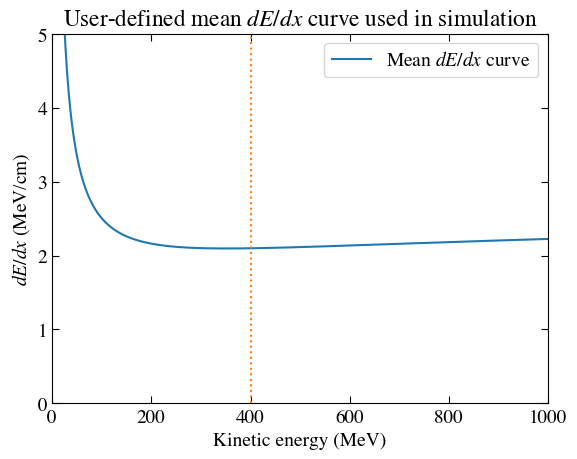

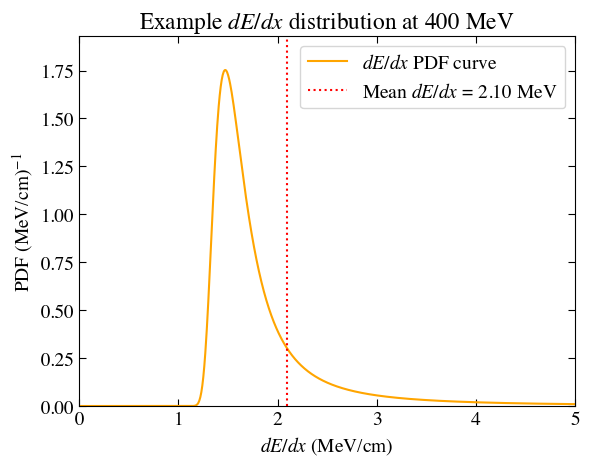

In [3]:
### dE/dx as a function of KE described by Bethe-Bloch formula
dEdx_BBx, dEdx_BBy = np.loadtxt("inputs/dEdx_mean.txt")
dEdx_mean = lambda KE: np.interp(KE, dEdx_BBx, dEdx_BBy) # input from external pi-Ar dE/dx curve
### plot the simulated dE/dx curve
xx = np.arange(0, 1000.1, 1)
plt.plot(xx, dEdx_mean(xx), "-", label=r"Mean $dE/dx$ curve")
plt.xlim([0,1000])
ylim = [0,5]
plt.ylim(ylim)
plt.xlabel("Kinetic energy (MeV)")
plt.ylabel(r"$dE/dx$ (MeV/cm)")
plt.title(r"User-defined mean $dE/dx$ curve used in simulation")
test_KE = 400
plt.plot([test_KE]*2, ylim, ":")
plt.legend()
plt.savefig("figs/mean_dEdx.pdf")
plt.show()

### dE/dx distribution (Landau-Vavilov-Gaussian given pitch = 0.1 cm)
dEdx_pdfx, dEdx_pdfy = np.loadtxt("inputs/dEdx_pdf.txt")
pvxx, dEdx_ppf_arr_1, dEdx_ppf_arr_2, dEdx_ppf_arr_3 = np.loadtxt("inputs/dEdx_ppf.txt")
test_KE_1 = 400
dEdx_ppf_landau = lambda KE: np.interp(KE, pvxx, dEdx_ppf_arr_1)
test_KE_2 = 20
dEdx_ppf_vavilov = lambda KE: np.interp(KE, pvxx, dEdx_ppf_arr_2)
test_KE_3 = 2
dEdx_ppf_gaussian = lambda KE: np.interp(KE, pvxx, dEdx_ppf_arr_3)

def dEdx_rdm(KE): # generate random value following the dE/dx distribution at a certain KE
    pv = np.random.rand() # a random number uniformly distributed in [0, 1]
    if KE > 83.85: # Landau
        return dEdx_ppf_landau(pv) + dEdx_mean(KE)-dEdx_mean(test_KE_1)
    if KE > 2.15: # Vavilov
        return dEdx_ppf_vavilov(pv) + dEdx_mean(KE)-dEdx_mean(test_KE_2)
    else: # Gaussian
        return dEdx_ppf_gaussian(pv) + dEdx_mean(KE)-dEdx_mean(test_KE_3)

### plot the dE/dx curve with the test KE
plt.plot(dEdx_pdfx, dEdx_pdfy, "orange", label=r"$dE/dx$ PDF curve")
ylim = [0, 1.1*np.max(dEdx_pdfy)]
test_dEdx = dEdx_mean(test_KE)
plt.plot([test_dEdx]*2, ylim, "r:", label=rf"Mean $dE/dx$ = {test_dEdx:.2f} MeV")
plt.xlim([0, dEdx_pdfx[-1]])
plt.ylim(ylim)
plt.xlabel(r"$dE/dx$ (MeV/cm)")
plt.ylabel(r"PDF (MeV/cm)$^{-1}$")
plt.title(r"Example $dE/dx$ distribution at 400 MeV")
plt.legend()
plt.savefig("figs/dEdx_PDF.pdf")
plt.show()

### Generate the simulation sample
We divide the track into several steps with a certain path length, and calculate its possibility to have interactions in each step,and use random number to decide if it interacts or not in each step.

In [4]:
def if_interaction_step(KE, x_step): # whether the probe particle interacts with the material atom in a step
    
    Pint_ex = n_tar * XS_gen_ex(KE)/1e27 * x_step # possibility to have the signal interaction in a step
    Pint_oth = n_tar * XS_gen_oth(KE)/1e27 * x_step # possibility to have other interactions in a step
    
    judg = np.random.rand()
    if (judg < Pint_ex):
        return 1 # signal interaction
    elif (judg < Pint_ex+Pint_oth):
        return 2 # other interactions
    else:
        return 0 # no interaction

def interaction_sim(KE, x_step): # simulate step-by-step, until the probe interacts with the material atom or stops to rest
    flag = 0
    while flag == 0:
        flag = if_interaction_step(KE, x_step)
        dEdx = dEdx_rdm(KE)
        Edeposition = dEdx * x_step
        KE -= Edeposition
        if (KE <= 0):
            return 0, 0
    return KE, flag # the final energy of the probe particle; a flag indicating the type of interaction

Number of MC events generated: 100000
  processing events 0/100000...
  processing events 1000/100000...
  processing events 2000/100000...
  processing events 3000/100000...
  processing events 4000/100000...
  processing events 5000/100000...
  processing events 6000/100000...
  processing events 7000/100000...
  processing events 8000/100000...
  processing events 9000/100000...
  processing events 10000/100000...
  processing events 11000/100000...
  processing events 12000/100000...
  processing events 13000/100000...
  processing events 14000/100000...
  processing events 15000/100000...
  processing events 16000/100000...
  processing events 17000/100000...
  processing events 18000/100000...
  processing events 19000/100000...
  processing events 20000/100000...
  processing events 21000/100000...
  processing events 22000/100000...
  processing events 23000/100000...
  processing events 24000/100000...
  processing events 25000/100000...
  processing events 26000/100000...
  p

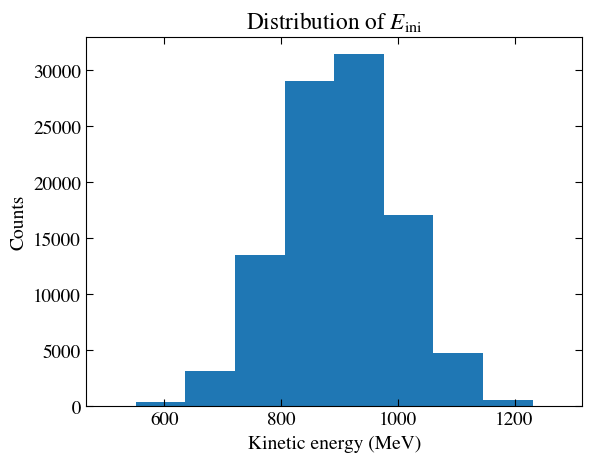

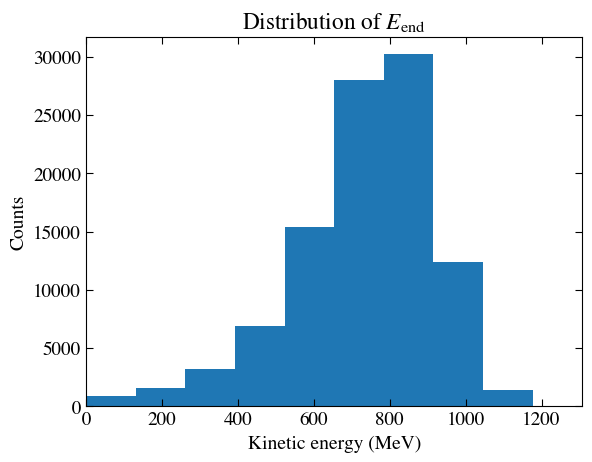

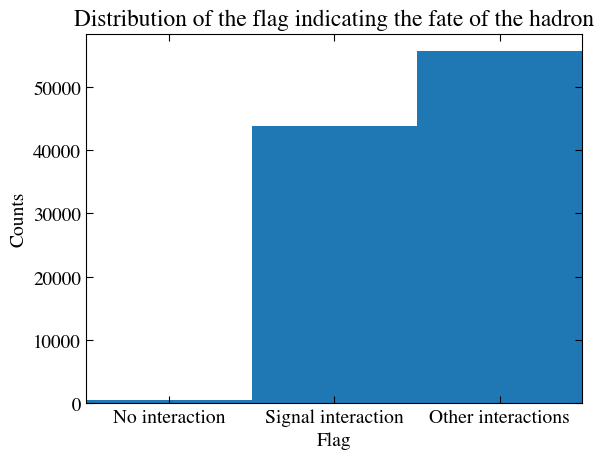

In [5]:
x_step = 0.1 # step size (cm)
Nevts = 100000 # number of events to be generated
print("Number of MC events generated:", Nevts)

trueKEi = np.random.normal(900, 100, Nevts) # initial energy of all events
trueKEf = [] # final energy of all events
int_type = [] # interaction type of all events

for ievt in range(Nevts):
    if (ievt%(10000*x_step)==0):
        print(f"  processing events {ievt}/{Nevts}...")
    KE, flag = interaction_sim(trueKEi[ievt], x_step)
    trueKEf.append(KE)
    int_type.append(flag)

trueKEf = np.array(trueKEf)
print("Sample generated.")

# plot the distribution of initial energy and final energy
_,bins,_ = plt.hist(trueKEi)
plt.xlabel("Kinetic energy (MeV)")
plt.ylabel("Counts")
plt.title(r"Distribution of $E_{\rm ini}$")
plt.xlim([bins[0],bins[-1]])
plt.savefig("figs/true_Eini.pdf")
plt.show()
_,bins,_ = plt.hist(trueKEf)
plt.xlabel("Kinetic energy (MeV)")
plt.ylabel("Counts")
plt.title(r"Distribution of $E_{\rm end}$")
plt.xlim([bins[0],bins[-1]])
plt.savefig("figs/true_Eend.pdf")
plt.show()
fig, ax = plt.subplots()
_,bins,_ = plt.hist(int_type, bins=range(4))
plt.xlabel("Flag")
plt.ylabel("Counts")
ax.set_xticks(np.arange(0.5,3), labels=["No interaction","Signal interaction","Other interactions"])
plt.title("Distribution of the flag indicating the fate of the hadron")
plt.xlim([bins[0],bins[-1]])
plt.savefig("figs/true_intype.pdf")
plt.show()

## Part 2. Extract cross-section using the truth information
The initial energy, final energy, and the interaction type for each simulated event are their truth information. We will use slicing method to calculate the cross-section using the truth information.

The references at the end might be useful to understand the definition of the slice ID for initial histogram, end histogram, and interaction histogram.

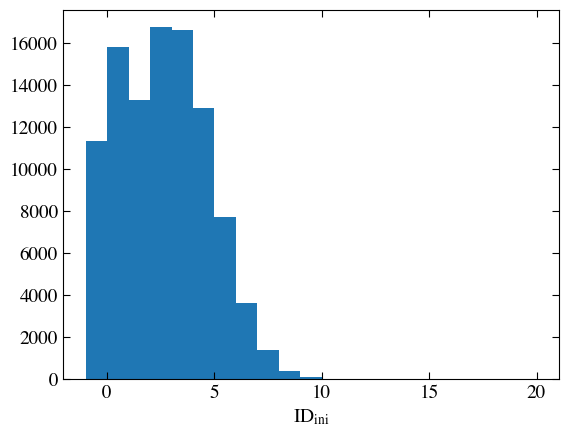

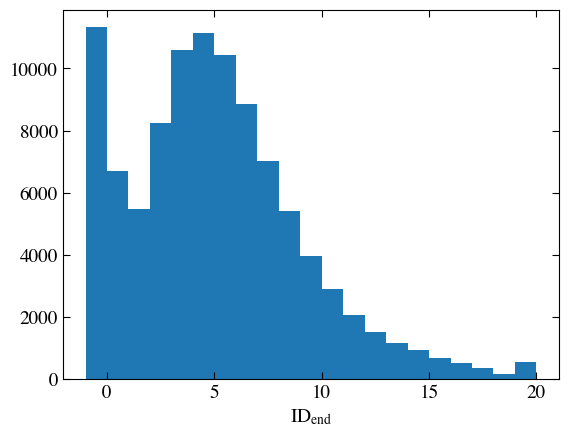

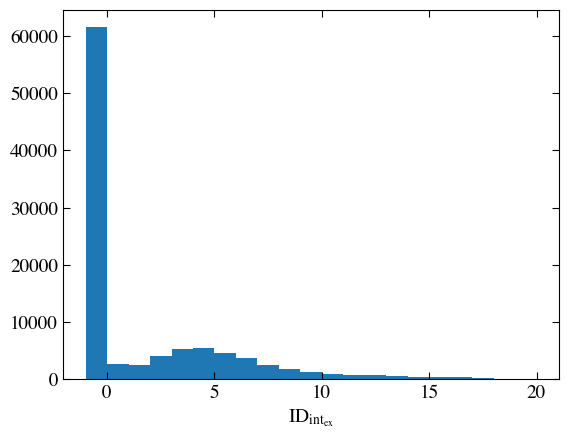

In [6]:
### define the energy binning
true_bins = np.array([1000,950,900,850,800,750,700,650,600,550,500,450,400,350,300,250,200,150,100,50,0])
Ntruebins = len(true_bins)
true_cKE = (true_bins[:-1] + true_bins[1:])/2 # energy bin centers
true_wKE = (true_bins[:-1] - true_bins[1:])/2 # energy bin half-width

### slice ID histograms using truth info 
### sliceID == 0 as underflow (too low KE); sliceID == Ntruebins-1 as overflow (too high KE); sliceID == -1 as unphysical bin (null value)
true_SIDini = []
true_SIDend = []
true_SIDint_ex = []
for ievt in range(Nevts):
    KE_ini = trueKEi[ievt]
    KE_end = trueKEf[ievt]
    intrcn = int_type[ievt]
    
    ## derive the initial slice ID
    for SID_ini in range(Ntruebins-1):
        if true_bins[SID_ini] < KE_ini:
            break
            
    ## derive the final slice ID
    for SID_end in range(Ntruebins-1):
        if true_bins[SID_end+1] < KE_end:
            break
    
    ## remove incomplete slices
    if SID_end < SID_ini:
        SID_ini = -1
        SID_end = -1
        
    ## derive the signal interaction slice ID
    SID_int_ex = SID_end
    if intrcn != 1:
        SID_int_ex = -1
        
    true_SIDini.append(SID_ini)
    true_SIDend.append(SID_end)
    true_SIDint_ex.append(SID_int_ex)
            
### plot the truth slice ID histograms
true_Nini,_,_ = plt.hist(true_SIDini, range(-1, Ntruebins))
plt.xlabel(r"${\rm ID_{ini}}$")
plt.show()
true_Nend,_,_ = plt.hist(true_SIDend, range(-1, Ntruebins))
plt.xlabel(r"${\rm ID_{end}}$")
plt.show()
true_Nint_ex,_,_ = plt.hist(true_SIDint_ex, range(-1, Ntruebins))
plt.xlabel(r"${\rm ID_{int_{ex}}}$")
plt.show()
### do not use the null bin
true_Nini = true_Nini[1:]
true_Nend = true_Nend[1:]
true_Nint_ex = true_Nint_ex[1:]

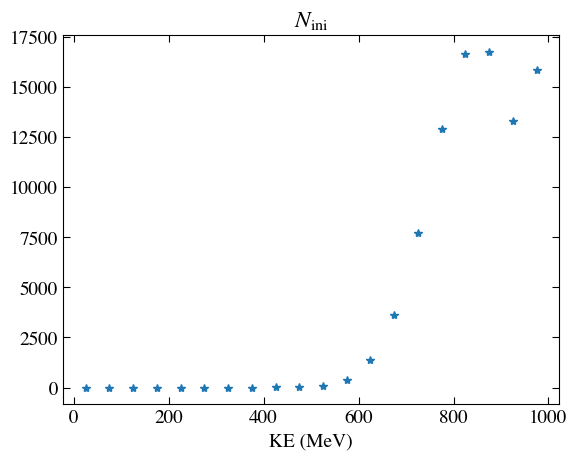

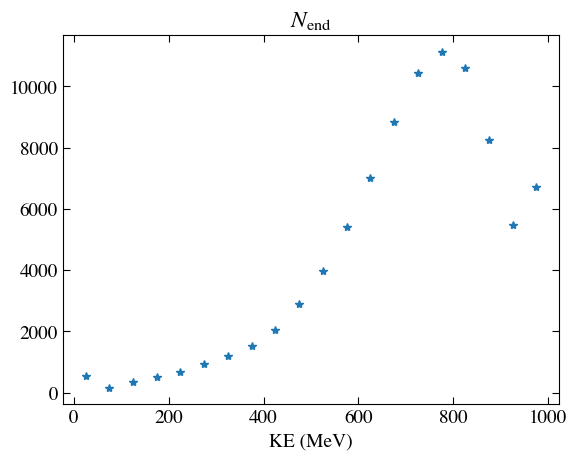

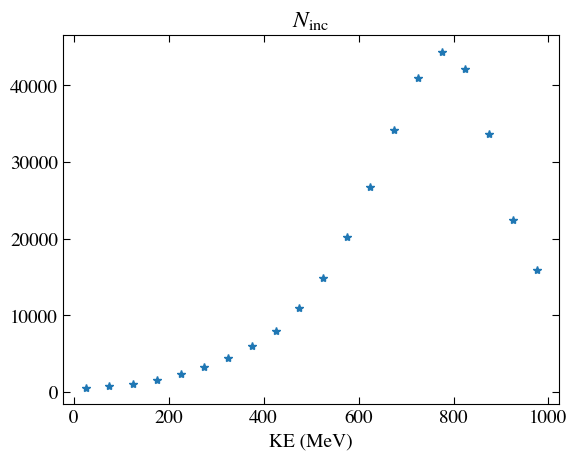

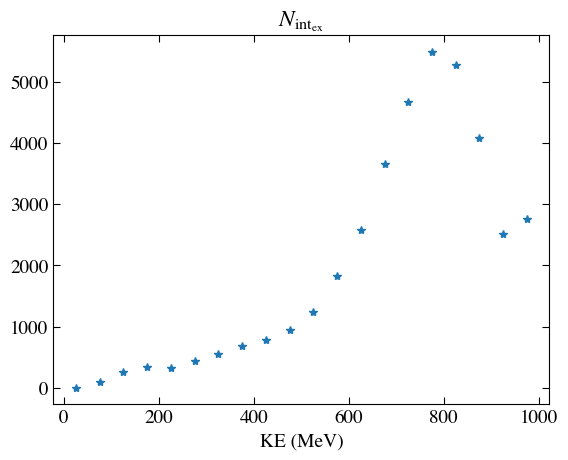

In [7]:
### derive the incident histogram
true_Ninc = np.zeros_like(true_Nini)
for ibin in range(Ntruebins-1): # again, the formula can be found in the reference below
    ## two equivalent way to calculate the incident histogram
    for itmp in range(0, ibin+1):
        true_Ninc[ibin] += true_Nini[itmp]
    for itmp in range(0, ibin):
        true_Ninc[ibin] -= true_Nend[itmp]
    '''for itmp in range(ibin, Ntruebins-1):
        true_Ninc[ibin] += true_Nend[itmp]
    for itmp in range(ibin+1, Ntruebins-1):
        true_Ninc[ibin] -= true_Nini[itmp]'''

### plot the histograms related to the cross-section calculation
plt.plot(true_cKE, true_Nini, "*")
plt.title(r"$N_{\rm ini}$")
plt.xlabel("KE (MeV)")
plt.show()
plt.plot(true_cKE, true_Nend, "*")
plt.title(r"$N_{\rm end}$")
plt.xlabel("KE (MeV)")
plt.show()
plt.plot(true_cKE, true_Ninc, "*")
plt.title(r"$N_{\rm inc}$")
plt.xlabel("KE (MeV)")
plt.show()
plt.plot(true_cKE, true_Nint_ex, "*")
plt.title(r"$N_{\rm int_{ex}}$")
plt.xlabel("KE (MeV)")
plt.show()

### Calculate the signal cross-section
Plug into the formula $\sigma(E)=\frac{N_{\rm int}(E)}{nN_{\rm end}(E)\delta E}\frac{dE}{dx}(E)\ln\left(\frac{N_{\rm inc}(E)}{N_{\rm inc}(E)-N_{\rm end}(E)}\right)$ to calculate the central values for signal cross-section, and overlay with the input XS curve for a quick visual comparison. We will calculate uncertainty later as well as compare the extracted truth XS with the input curve quantitatively.

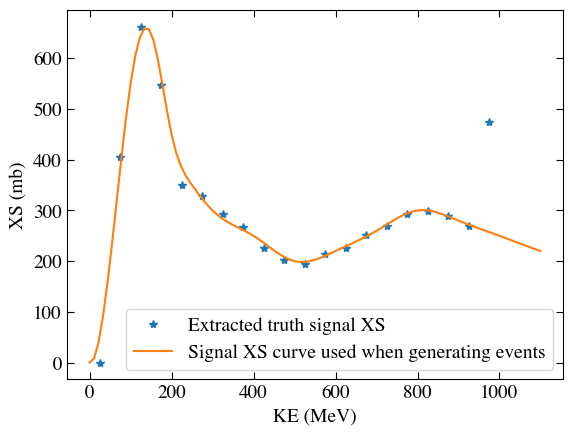

In [8]:
true_XS = np.zeros_like(true_Nini)
for ibin in range(Ntruebins-1):
    prefact = dEdx_mean(true_cKE[ibin]) / (n_tar*true_wKE[ibin]*2) * 1e27 # pre-factor
    Ninc = true_Ninc[ibin]
    Nend = true_Nend[ibin]
    Nint_ex = true_Nint_ex[ibin]
    
    if Nend == 0 or Ninc-Nend == 0: # no track ends in this bin, or all tracks end in this bin
        true_XS[ibin] = 0
    else:    
        true_XS[ibin] = prefact * Nint_ex/Nend * np.log(Ninc/(Ninc-Nend))
    
### plot the signal cross-section extracted using the truth info
plt.plot(true_cKE, true_XS, "*", label="Extracted truth signal XS")
xx = np.linspace(0, 1100, 100)
plt.plot(xx,XS_gen_ex(xx), label="Signal XS curve used when generating events") # overlay with the input XS curve
plt.xlabel("KE (MeV)")
plt.ylabel("XS (mb)") # 1 mb = 10^{-27} cm^2
plt.legend()
plt.show()

## Part 3. Error propagation
Let's now calculate the statistical uncertainty! Remember each event has three slice IDs, which are `true_SIDini`, `true_SIDend`, `true_SIDint_ex`. Above we define `Nevts` as the number of events, `Ntruebins` as the number of energy bins.

In order to fully consider the correlations, we combine the three slice IDs into a single variable $(\rm ID_{ini}, {\rm ID_{end}}, {\rm ID_{int_{ex}}})$, whose ID is denoted as ${\rm ID_{3D}}={\rm ID_{ini}}+N_{\rm bin}\cdot{\rm ID_{end}}+N_{\rm bin}^2\cdot{\rm ID_{int_{ex}}}$. (It is similar to flattening a 3D histogram into a 1D histogram.)

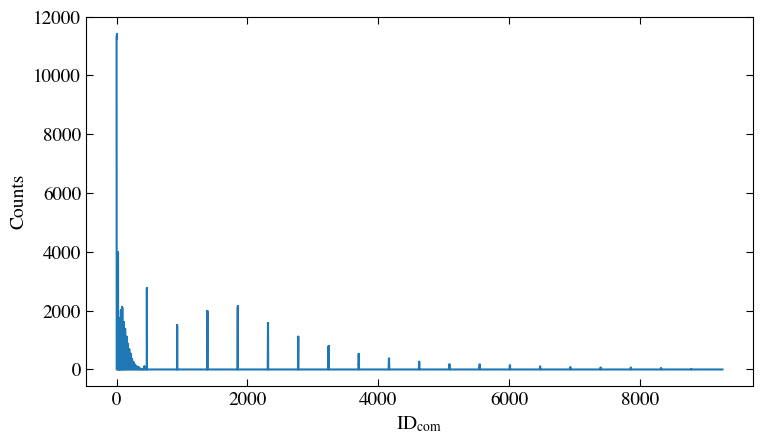

In [9]:
Ntruebins_3D = Ntruebins**3 # number of bins for the combined variable
true_N3D = np.zeros(Ntruebins_3D)
true_N3D_err = np.zeros(Ntruebins_3D)
true_SID3D = np.zeros(Nevts, dtype=np.int32)
evtweight = np.ones(Nevts) # TB implement weight for each event in previous cells

for ievt in range(Nevts): # fill in the combined variable
    SID_ini = true_SIDini[ievt] + 1 # so that null bin moves to 0 (covenient for integer division and modulus below)
    SID_end = true_SIDend[ievt] + 1
    SID_int_ex = true_SIDint_ex[ievt] + 1
    weight = evtweight[ievt]
    
    SID3D = SID_ini + Ntruebins * SID_end + Ntruebins*Ntruebins * SID_int_ex # definition of the combined variable
    true_SID3D[ievt] = SID3D
    
    true_N3D[SID3D] += weight
    true_N3D_err[SID3D] += weight*weight

true_N3D_Vcov = np.diag(true_N3D_err) # this is a fill process. Each bin is independent, so the covariance matrix is diagonal
true_N3D_err = np.sqrt(true_N3D_err)
plt.figure(figsize=[8.6,4.8])
plt.errorbar(np.arange(0, Ntruebins_3D), true_N3D, true_N3D_err)
plt.xlabel(r"${\rm ID_{com}}$")
plt.ylabel("Counts")
plt.savefig("figs/true_IDcom.pdf")
plt.show()


Plot the correlation matrix. Although it is diagonal (and too sparse to be seen).

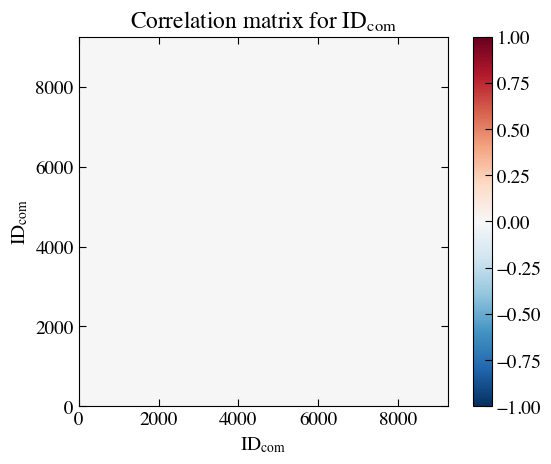

In [10]:
def transform_cov_to_corr_matrix(cov): # a useful function to get correlation matrix from a covariance matrix
    corr = np.zeros_like(cov)
    nrows = len(cov)
    ncols = len(cov[0])
    if nrows != ncols:
        raise Exception("Input covariance matrix is not square!")
    for ir in range(nrows):
        for ic in range(ncols):
            if cov[ir, ic] != 0:
                corr[ir, ic] = cov[ir, ic]/np.sqrt(cov[ir, ir]*cov[ic, ic])
    return corr
plt.figure()
plt.imshow(transform_cov_to_corr_matrix(true_N3D_Vcov), origin="lower", cmap="RdBu_r", vmin=-1, vmax=1)
plt.title(r"Correlation matrix for ${\rm ID_{com}}$")
plt.xlabel(r"${\rm ID_{com}}$")
plt.ylabel(r"${\rm ID_{com}}$")
plt.colorbar()
plt.savefig("figs/corr_mat_true_1.pdf")#, dpi=4000)
plt.show()

### Build Jacobian matrix fo error propagation 
We follow the standard error propagation procedures, by constructing Jacobian matrix, defined as 
$J=\begin{pmatrix}
        \frac{\partial f_1}{\partial x_1} & \cdots & \frac{\partial f_1}{\partial x_n} \\
        \vdots & \ddots & \vdots \\
        \frac{\partial f_m}{\partial x_1} & \cdots & \frac{\partial f_m}{\partial x_n}
    \end{pmatrix}_{(m\times n)}$, 

and thus the transformation of covariance matrix is $V_{f}=J\cdot V_x\cdot J^T$.
    
There are three steps before transforming to the final cross-section variables. In each step, a Jacobian matrix is needed, whose constructions is rather tricky on a case-by-case basis. The codes below as well as the references at the end might be helpful.

**Firstly**, transform from the combined variable $(\rm ID_{ini}, {\rm ID_{end}}, {\rm ID_{int_{ex}}})$ back to its projections, the three slice IDs $(\rm ID_{ini}; {\rm ID_{end}}; {\rm ID_{int_{ex}}})$. This step may look superfluous, but only in this way we get the correlations among different slice IDs. As we will see in the correlation matrix ouput by the following cell, the off-diagonal blocks are not empty.

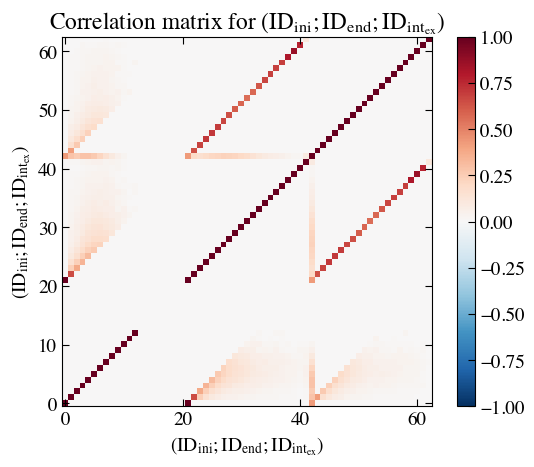

In [11]:
### construction the Jacobian matrix Jac_N3D_3SID
Jac_N3D_3SID = np.zeros([3*Ntruebins, Ntruebins_3D])
for jbin in range(Ntruebins_3D):
    ## use integer division and modulus to project back to 1D histograms
    ibx = jbin % Ntruebins # get SID_ini
    iby = (jbin // Ntruebins) % Ntruebins # get SID_end
    ibz = (jbin // Ntruebins // Ntruebins) % Ntruebins # get SID_int_ex
    Jac_N3D_3SID[ibx, jbin] = 1
    Jac_N3D_3SID[Ntruebins+iby, jbin] = 1
    Jac_N3D_3SID[2*Ntruebins+ibz, jbin] = 1
#print(Jac_N3D_3SID) # in case you want to take a look

### derive the covariance matrix true_3SID_Vcov
#true_3SID_Vcov = np.einsum("ij,jk,lk->il", Jac_N3D_3SID, true_N3D_Vcov, Jac_N3D_3SID) # computation too slow
true_3SID_Vcov = np.einsum("ij,jk->ik", Jac_N3D_3SID, true_N3D_Vcov)
true_3SID_Vcov = np.einsum("ij,kj->ik", true_3SID_Vcov, Jac_N3D_3SID)

plt.imshow(transform_cov_to_corr_matrix(true_3SID_Vcov), origin="lower", cmap="RdBu_r", vmin=-1, vmax=1)
plt.title(r"Correlation matrix for $(\rm ID_{ini}; {\rm ID_{end}}; {\rm ID_{int_{ex}}})$")
plt.xlabel(r"$(\rm ID_{ini}; {\rm ID_{end}}; {\rm ID_{int_{ex}}})$")
plt.ylabel(r"$(\rm ID_{ini}; {\rm ID_{end}}; {\rm ID_{int_{ex}}})$")
plt.colorbar()
plt.savefig("figs/corr_mat_true_2.pdf")
plt.show()

**Secondly**, transform from the three slice IDs $(\rm ID_{ini}; {\rm ID_{end}}; {\rm ID_{int_{ex}}})$ to the histograms $(N_{\rm inc}; N_{\rm end}; N_{\rm int_{ex}})$, which appear in the cross-section formula.

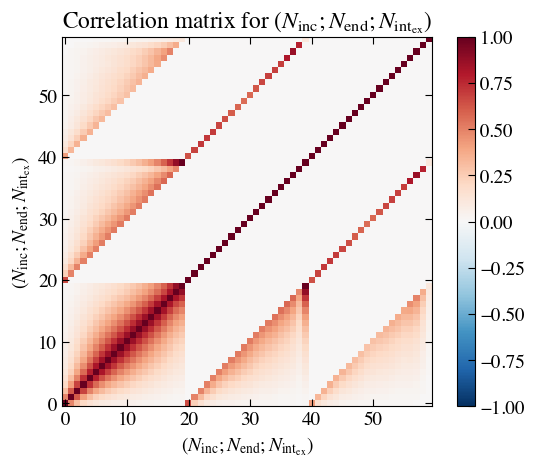

In [12]:
### construction the Jacobian matrix Jac_3SID_3N
Jac_3SID_3N = np.zeros([3*(Ntruebins-1), 3*Ntruebins])
for ibin in range(Ntruebins-1): # for true_Ninc
    ## two equivalent way to calculate the incident histogram
    for jbin in range(ibin+2, Ntruebins):
        Jac_3SID_3N[ibin, jbin] = -1
    for jbin in range(ibin+1+Ntruebins, 2*Ntruebins):
        Jac_3SID_3N[ibin, jbin] = 1
    '''for jbin in range(1, ibin+2):
        Jac_3SID_3N[ibin, jbin] = 1
    for jbin in range(1+Ntruebins, ibin+1+Ntruebins):
        Jac_3SID_3N[ibin, jbin] = -1'''
for ibin in range(Ntruebins-1, 2*(Ntruebins-1)): # for true_Nend
    Jac_3SID_3N[ibin, ibin+2] = 1
for ibin in range(2*(Ntruebins-1), 3*(Ntruebins-1)): # for true_Nint_ex
    Jac_3SID_3N[ibin, ibin+3] = 1
#print(Jac_3SID_3N) # in case you want to take a look

### derive the covariance matrix true_3N_Vcov
true_3N_Vcov = np.einsum("ij,jk,lk->il", Jac_3SID_3N, true_3SID_Vcov, Jac_3SID_3N)

plt.imshow(transform_cov_to_corr_matrix(true_3N_Vcov), origin="lower", cmap="RdBu_r", vmin=-1, vmax=1)
plt.title(r"Correlation matrix for $(N_{\rm inc}; N_{\rm end}; N_{\rm int_{ex}})$")
plt.xlabel(r"$(N_{\rm inc}; N_{\rm end}; N_{\rm int_{ex}})$")
plt.ylabel(r"$(N_{\rm inc}; N_{\rm end}; N_{\rm int_{ex}})$")
plt.colorbar()
plt.savefig("figs/corr_mat_true_3.pdf")
plt.show()

With this, we can evaulate uncertainty for the histograms related to the cross-section calculation.

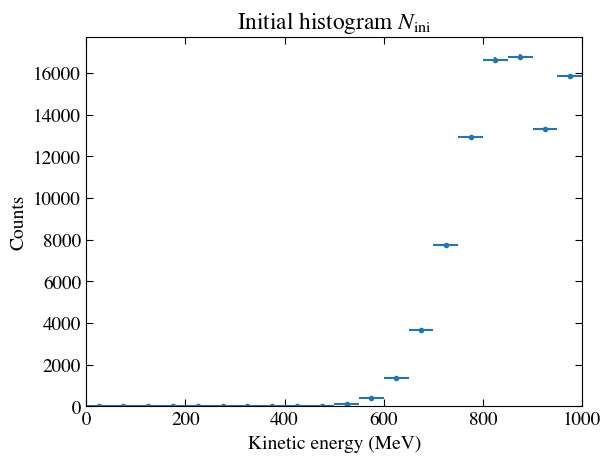

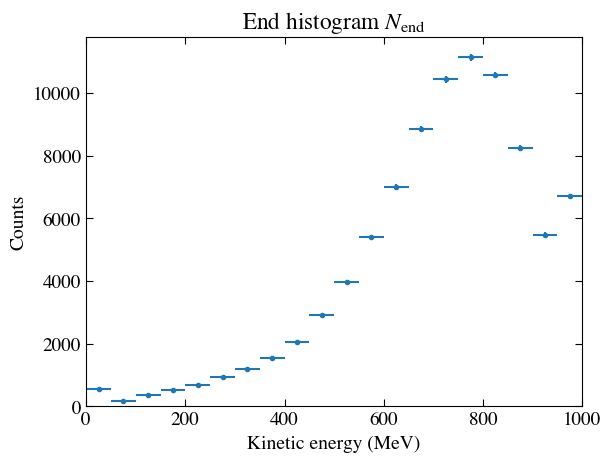

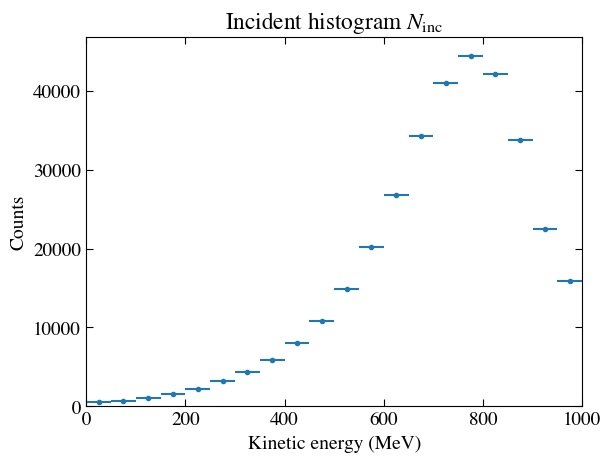

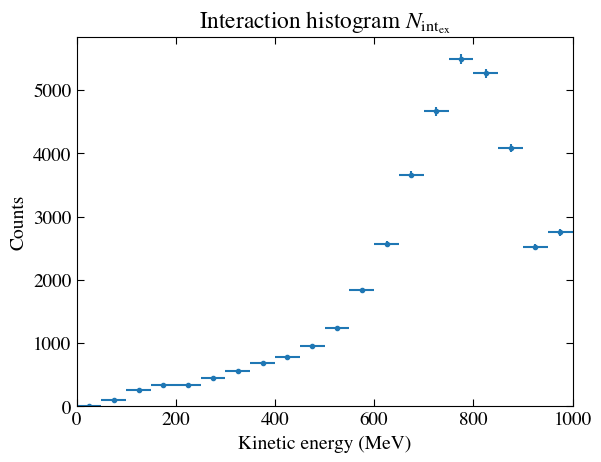

In [13]:
### get the uncertainty from the covariance matrix
true_Nini_err = np.sqrt(np.diagonal(true_3SID_Vcov)[1:Ntruebins])
true_Ninc_err = np.sqrt(np.diagonal(true_3N_Vcov)[:Ntruebins-1])
true_Nend_err = np.sqrt(np.diagonal(true_3N_Vcov)[Ntruebins-1:2*(Ntruebins-1)])
true_Nint_ex_err = np.sqrt(np.diagonal(true_3N_Vcov)[2*(Ntruebins-1):])

### plot the histograms related to the cross-section calculation with statistical uncertainty
plt.errorbar(true_cKE, true_Nini, true_Nini_err, true_wKE, ".")
plt.title(r"Initial histogram $N_{\rm ini}$")
plt.xlabel("Kinetic energy (MeV)")
plt.ylabel("Counts")
plt.xlim([0,1000])
plt.ylim(bottom=0)
plt.savefig("figs/Nini.pdf")
plt.show()
plt.errorbar(true_cKE, true_Nend, true_Nend_err, true_wKE, ".")
plt.title(r"End histogram $N_{\rm end}$")
plt.xlabel("Kinetic energy (MeV)")
plt.ylabel("Counts")
plt.xlim([0,1000])
plt.ylim(bottom=0)
plt.savefig("figs/Nend.pdf")
plt.show()
plt.errorbar(true_cKE, true_Ninc, true_Ninc_err, true_wKE, ".")
plt.title(r"Incident histogram $N_{\rm inc}$")
plt.xlabel("Kinetic energy (MeV)")
plt.ylabel("Counts")
plt.xlim([0,1000])
plt.ylim(bottom=0)
plt.savefig("figs/Nint.pdf")
plt.show()
plt.errorbar(true_cKE, true_Nint_ex, true_Nint_ex_err, true_wKE, ".")
plt.title(r"Interaction histogram $N_{\rm int_{ex}}$")
plt.xlabel("Kinetic energy (MeV)")
plt.ylabel("Counts")
plt.xlim([0,1000])
plt.ylim(bottom=0)
plt.savefig("figs/Ninc.pdf")
plt.show()

**Thirdly**, transform from the histograms $(N_{\rm inc}; N_{\rm end}; N_{\rm int_{ex}})$ to cross-section.

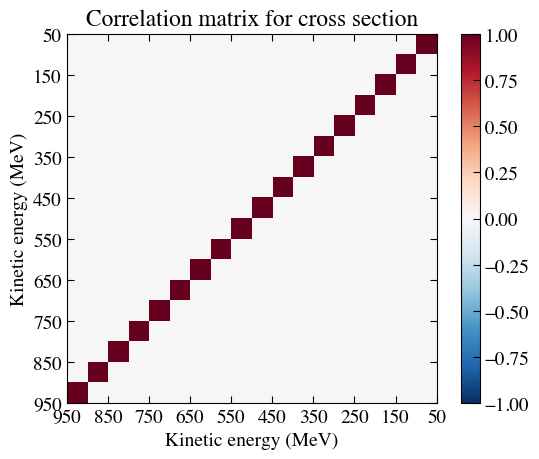

In [14]:
### construction the Jacobian matrix Jac_3N_XS_true
Jac_3N_XS_true = np.zeros([Ntruebins-1, 3*(Ntruebins-1)])
for ibin in range(Ntruebins-1):
    prefact = dEdx_mean(true_cKE[ibin]) / (n_tar*true_wKE[ibin]*2) * 1e27 # pre-factor
    Ninc = true_Ninc[ibin]
    Nend = true_Nend[ibin]
    Nint_ex = true_Nint_ex[ibin]
    
    if Nend == 0 or Ninc-Nend == 0: # no track ends in this bin, or all tracks end in this bin
        #true_XS[ibin] = 0
        Jac_3N_XS_true[ibin, ibin] = 0
        Jac_3N_XS_true[ibin, ibin+Ntruebins-1] = 0
        Jac_3N_XS_true[ibin, ibin+2*(Ntruebins-1)] = 0
    else:
        #true_XS[ibin] = prefact * Nint_ex/Nend * np.log(Ninc/(Ninc-Nend)) # same as above when we calculate the signal cross-section σ 
        Jac_3N_XS_true[ibin, ibin] = prefact * Nint_ex / Ninc / (Nend-Ninc) # ∂σ/∂Ninc
        Jac_3N_XS_true[ibin, ibin+Ntruebins-1] = prefact * Nint_ex/Nend * (1/(Ninc-Nend) - 1/Nend*np.log(Ninc/(Ninc-Nend))) # ∂σ/∂Nend
        Jac_3N_XS_true[ibin, ibin+2*(Ntruebins-1)] = prefact * 1 / Nend *np.log(Ninc/(Ninc-Nend)) # ∂σ/∂Nint_ex
#print(Jac_3N_XS_true) # in case you want to take a look

### derive the covariance matrix true_XS_Vcov
true_XS_Vcov = np.einsum("ij,jk,lk->il", Jac_3N_XS_true, true_3N_Vcov, Jac_3N_XS_true)

plt.imshow(transform_cov_to_corr_matrix(true_XS_Vcov[1:-1, 1:-1]), origin="lower", cmap="RdBu_r", vmin=-1, vmax=1, extent = [950,50,950,50])
plt.title(r"Correlation matrix for cross section")
plt.xticks([950,850,750,650,550,450,350,250,150,50])
plt.yticks([950,850,750,650,550,450,350,250,150,50])
plt.xlabel(r"Kinetic energy (MeV)")
plt.ylabel(r"Kinetic energy (MeV)")
plt.colorbar()
plt.savefig("figs/corr_mat_true_4.pdf")
plt.show()

Now we can get the cross-section with properly evaluated statistical uncertainty. The central value together with the covariance matrix derived above constitute the result. We can calculate $\chi^2$ against the input XS curve as a quantitative way to compare the result.

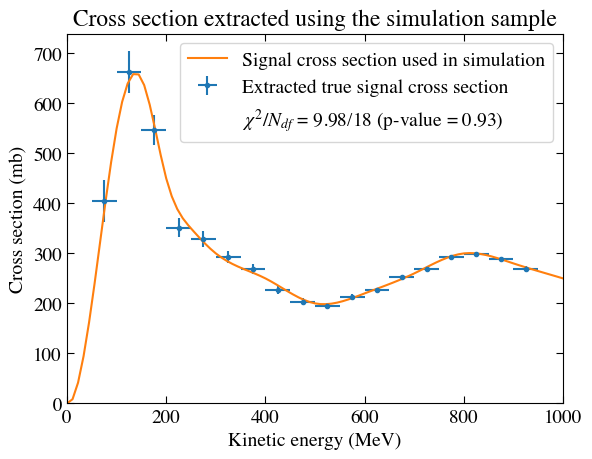

In [15]:
### plot the signal cross-section extracted using the truth info with statistical uncertainty
XS_x = true_cKE[1:-1] # the underflow and overflow bin are not used
XS_y = true_XS[1:-1]
XS_xerr = true_wKE[1:-1]
XS_yerr = np.sqrt(np.diagonal(true_XS_Vcov))[1:-1] # get the uncertainty from the covariance matrix
plt.errorbar(XS_x, XS_y, XS_yerr, XS_xerr, fmt=".", label="Extracted true signal cross section")
xx = np.linspace(0, 1100, 100)
plt.plot(xx,XS_gen_ex(xx), label="Signal cross section used in simulation")
plt.xlabel("Kinetic energy (MeV)")
plt.ylabel("Cross section (mb)") # 1 mb = 10^{-27} cm^2
plt.xlim([0,1000])
plt.ylim(bottom=0)
plt.title("Cross section extracted using the simulation sample")

### calculate chi^2
XS_diff = XS_y - XS_gen_ex(XS_x)
inv_true_XS_Vcov = np.linalg.pinv(true_XS_Vcov[1:-1, 1:-1])
chi2 = np.einsum("i,ij,j->", XS_diff, inv_true_XS_Vcov, XS_diff)
plt.plot([], [], ' ', label=rf"$\chi^2/N_{{df}}$ = {chi2:.2f}/{len(XS_diff)} (p-value = {1-stats.chi2.cdf(chi2, len(XS_diff)):.2f})") # print chi2 result

handles, labels = plt.gca().get_legend_handles_labels()
order = [0,2,1]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
plt.savefig("figs/trueXS.pdf")
plt.show()

## Part 4. Measuring effects
trueKEi, trueKEf, int_type

50183 events pass selections out of 100000 true events.


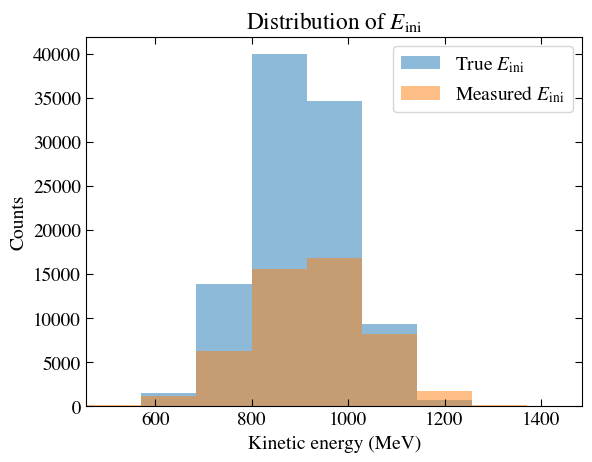

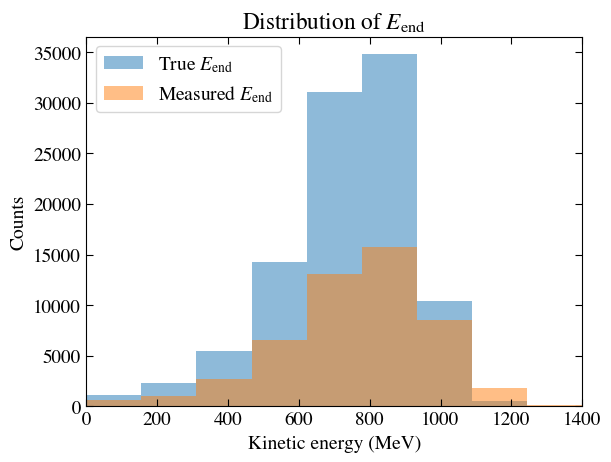

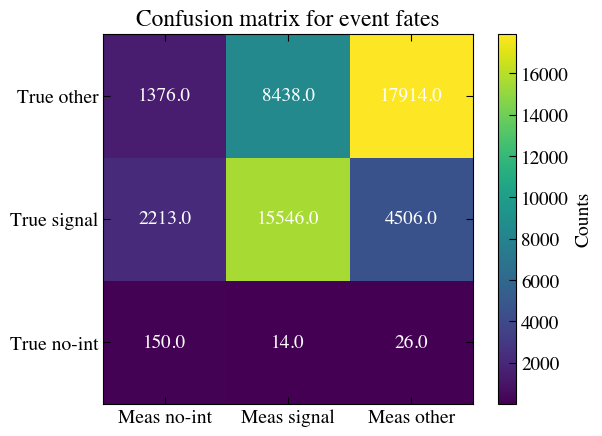

In [16]:
parscore = np.random.normal(0.6, 0.2, Nevts) # used for beam particle selection (select > 1) # TB add bkg events with np.random.normal(0.6, 0.4, Nbkg)
parscore += (trueKEi-500)/1000 # make the selection depends on trueKEi, so that the efficiency is not uniform 
measKEi = trueKEi[parscore>1]
measKEf = trueKEf[parscore>1]
Nselected_true_evts = len(measKEi)
print(f"{Nselected_true_evts} events pass selections out of {Nevts} true events.")
blurKEi = np.random.normal(-10, 80, Nselected_true_evts) # MeV
blurKEf = np.random.normal(10, 60, Nselected_true_evts) # MeV
measKEi += blurKEi
measKEf += (blurKEi + blurKEf)
measKEf = np.maximum(0, measKEf) # in case of negative measured KEf
# plot the distribution of initial energy and final energy
plt.hist(trueKEi, alpha=0.5, bins=np.linspace(min(measKEi),max(measKEi),10), label=r"True $E_{\rm ini}$")
plt.hist(measKEi, alpha=0.5, bins=np.linspace(min(measKEi),max(measKEi),10), label=r"Measured $E_{\rm ini}$")
plt.xlabel("Kinetic energy (MeV)")
plt.ylabel("Counts")
plt.title(r"Distribution of $E_{\rm ini}$")
plt.xlim([min(measKEi),max(measKEi)])
plt.legend()
plt.savefig("figs/meas_Eini.pdf")
plt.show()
plt.hist(trueKEf, alpha=0.5, bins=np.linspace(min(measKEf),max(measKEf),10), label=r"True $E_{\rm end}$")
plt.hist(measKEf, alpha=0.5, bins=np.linspace(min(measKEf),max(measKEf),10), label=r"Measured $E_{\rm end}$")
plt.xlabel("Kinetic energy (MeV)")
plt.ylabel("Counts")
plt.title(r"Distribution of $E_{\rm end}$")
plt.xlim([min(measKEf),max(measKEf)])
plt.legend()
plt.savefig("figs/meas_Eend.pdf")
plt.show()

### define the confusion matrix of the three interaction types
confus_mat_int_type = np.array([[0.8,0.1,0.1], [0.1,0.7,0.2], [0.05,0.3,0.65]]) # (0, 1, 2) == (no interaction, signal interaction, other interactions)
meas_int_type = np.array(int_type)[parscore>1]
tmp_rdm = np.random.rand(Nselected_true_evts)
confus_mat_int_type_mc = np.zeros([3,3])
for ievt in range(Nselected_true_evts):
    if meas_int_type[ievt] == 0:
        if tmp_rdm[ievt] < confus_mat_int_type[0,0]:
            confus_mat_int_type_mc[0,0] += 1
        elif tmp_rdm[ievt] < sum(confus_mat_int_type[0,0:-1]):
            meas_int_type[ievt] = 1
            confus_mat_int_type_mc[0,1] += 1
        else:
            meas_int_type[ievt] = 2
            confus_mat_int_type_mc[0,2] += 1
    elif meas_int_type[ievt] == 1:
        if tmp_rdm[ievt] < confus_mat_int_type[1,0]:
            meas_int_type[ievt] = 0
            confus_mat_int_type_mc[1,0] += 1
        elif tmp_rdm[ievt] < sum(confus_mat_int_type[1,0:-1]):
            confus_mat_int_type_mc[1,1] += 1
        else:
            meas_int_type[ievt] = 2
            confus_mat_int_type_mc[1,2] += 1
    elif meas_int_type[ievt] == 2:
        if tmp_rdm[ievt] < confus_mat_int_type[2,0]:
            meas_int_type[ievt] = 0
            confus_mat_int_type_mc[2,0] += 1
        elif tmp_rdm[ievt] < sum(confus_mat_int_type[2,0:-1]):
            meas_int_type[ievt] = 1
            confus_mat_int_type_mc[2,1] += 1
        else:
            confus_mat_int_type_mc[2,2] += 1
    else:
        raise Exception("Interaction type not in [0, 1, 2]!")

fig, ax = plt.subplots()
plt.imshow(confus_mat_int_type_mc, origin="lower")
for i in range(confus_mat_int_type_mc.shape[0]):
    for j in range(confus_mat_int_type_mc.shape[1]):
        plt.text(j, i, confus_mat_int_type_mc[i, j], ha="center", va="center", color="white")
ax.set_xticks(np.arange(3), labels=["Meas no-int","Meas signal","Meas other"])
ax.set_yticks(np.arange(3), labels=["True no-int","True signal","True other"])
plt.colorbar(label="Counts")
plt.title("Confusion matrix for event fates")
plt.savefig("figs/meas_intype.pdf")
plt.show()

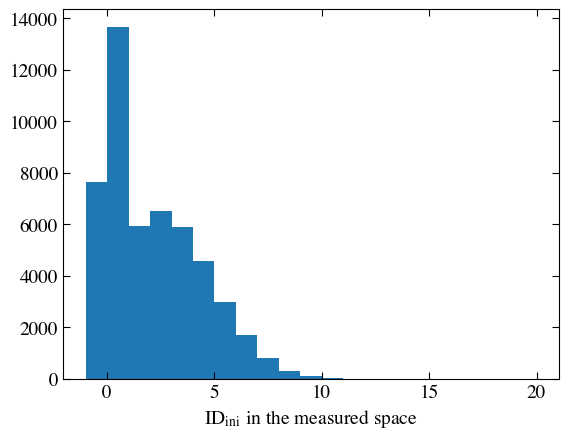

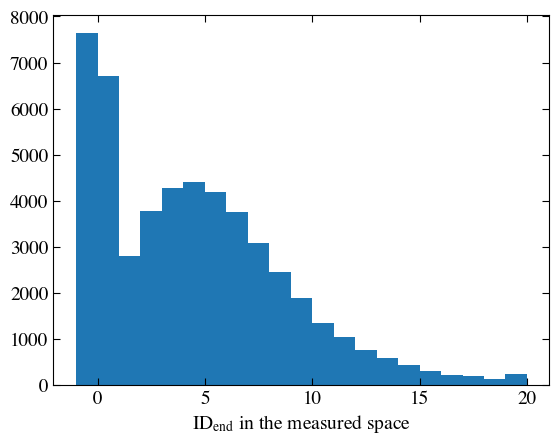

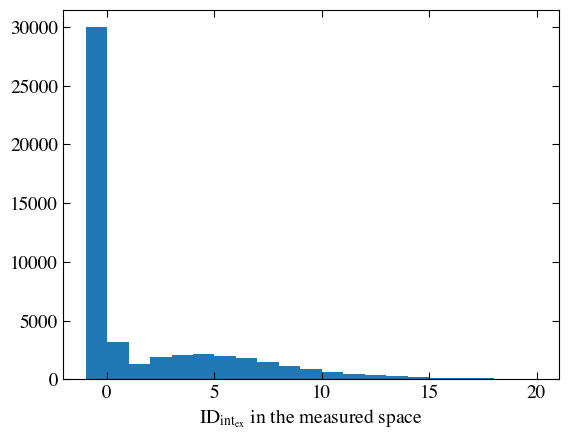

In [17]:
### define the energy binning
meas_bins = np.array([1000,950,900,850,800,750,700,650,600,550,500,450,400,350,300,250,200,150,100,50,0])
Nmeasbins = len(meas_bins)
meas_cKE = (meas_bins[:-1] + meas_bins[1:])/2 # energy bin centers
meas_wKE = (meas_bins[:-1] - meas_bins[1:])/2 # energy bin half-width

### slice ID histograms using measuring info 
### sliceID == 0 as underflow (too low KE); sliceID == Nrecobins-1 as overflow (too high KE); sliceID == -1 as unphysical bin (null value)
meas_SIDini = []
meas_SIDend = []
meas_SIDint_ex = []
for ievt in range(Nselected_true_evts):
    KE_ini = measKEi[ievt]
    KE_end = measKEf[ievt]
    intrcn = meas_int_type[ievt]
    
    ## derive the initial slice ID
    for SID_ini in range(Nmeasbins-1):
        if meas_bins[SID_ini] < KE_ini:
            break
            
    ## derive the final slice ID
    for SID_end in range(Nmeasbins-1):
        if meas_bins[SID_end+1] < KE_end:
            break
    
    ## remove incomplete slices
    if SID_end < SID_ini:
        SID_ini = -1
        SID_end = -1
        
    ## derive the signal interaction slice ID
    SID_int_ex = SID_end
    if intrcn != 1:
        SID_int_ex = -1
        
    meas_SIDini.append(SID_ini)
    meas_SIDend.append(SID_end)
    meas_SIDint_ex.append(SID_int_ex)
            
### plot the measured slice ID histograms
meas_Nini,_,_ = plt.hist(meas_SIDini, range(-1, Nmeasbins))
plt.xlabel(r"${\rm ID_{ini}}$ in the measured space")
plt.show()
meas_Nend,_,_ = plt.hist(meas_SIDend, range(-1, Nmeasbins))
plt.xlabel(r"${\rm ID_{end}}$ in the measured space")
plt.show()
meas_Nint_ex,_,_ = plt.hist(meas_SIDint_ex, range(-1, Nmeasbins))
plt.xlabel(r"${\rm ID_{int_{ex}}}$ in the measured space")
plt.show()

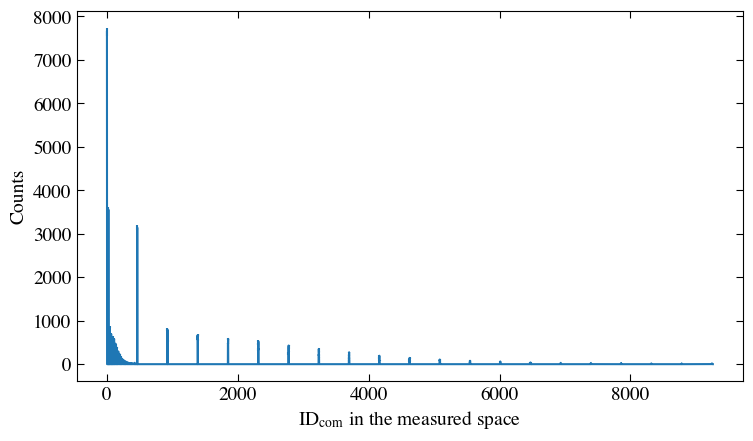

In [18]:
Nmeasbins_3D = Nmeasbins**3 # number of bins for the combined variable
meas_N3D = np.zeros(Nmeasbins_3D)
meas_N3D_err = np.zeros(Nmeasbins_3D)
meas_SID3D = np.zeros(Nselected_true_evts, dtype=np.int32)

for ievt in range(Nselected_true_evts): # fill in the combined variable
    SID_ini = meas_SIDini[ievt] + 1 # so that null bin moves to 0 (covenient for integer division and modulus below)
    SID_end = meas_SIDend[ievt] + 1
    SID_int_ex = meas_SIDint_ex[ievt] + 1
    weight = evtweight[ievt]
    
    SID3D = SID_ini + Nmeasbins * SID_end + Nmeasbins*Nmeasbins * SID_int_ex # definition of the combined variable
    meas_SID3D[ievt] = SID3D
    
    meas_N3D[SID3D] += weight
    meas_N3D_err[SID3D] += weight*weight # weighted Poisson error

meas_N3D_Vcov = np.diag(meas_N3D_err) # this is a fill process. Each bin is independent, so the covariance matrix is diagonal
meas_N3D_err = np.sqrt(meas_N3D_err)
plt.figure(figsize=[8.6,4.8])
plt.errorbar(np.arange(0, Nmeasbins_3D), meas_N3D, meas_N3D_err)
plt.xlabel(r"${\rm ID_{com}}$ in the measured space")
plt.ylabel("Counts")
plt.savefig("figs/meas_IDcom.pdf")
plt.show()
true_SID3D_sel = true_SID3D[parscore>1] # TB moved to somewhere before
true_N3D_sel, _ = np.histogram(true_SID3D_sel, bins=np.arange(Ntruebins_3D+1))


### 3D -> 1D

Ntruebins_1D = 309; Nmeasbins_1D = 332


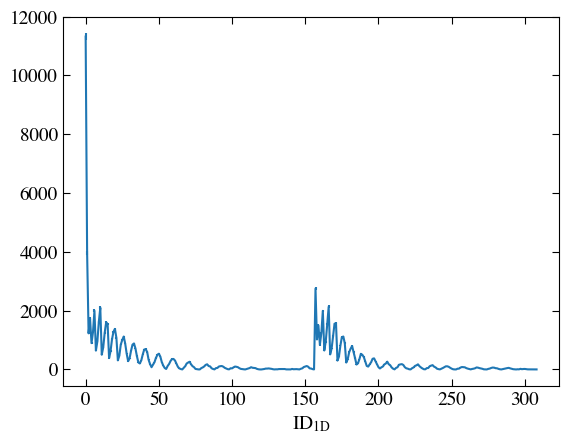

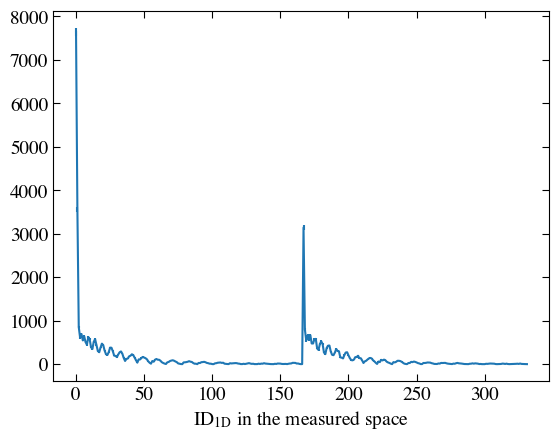

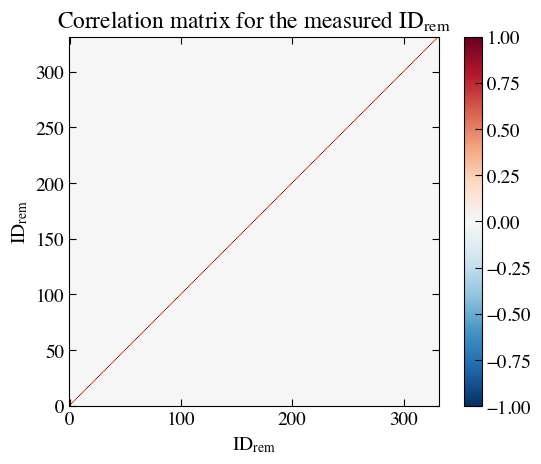

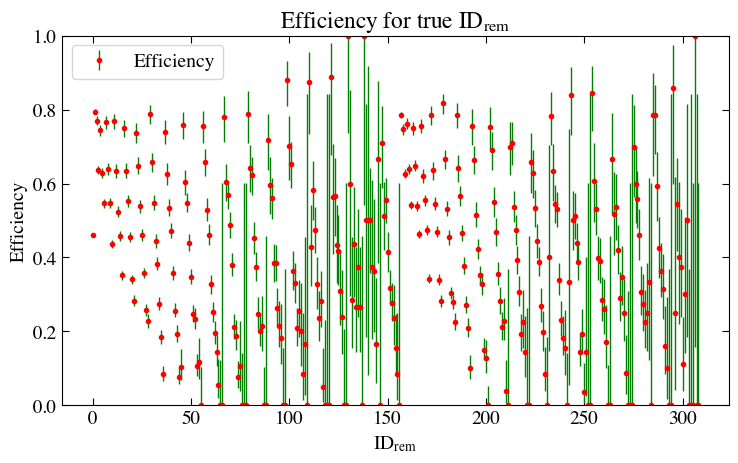

In [19]:
### mapping index from 3D to 1D
true_3D1D_map = np.zeros(Ntruebins_3D, dtype=np.int32)
meas_3D1D_map = np.zeros(Nmeasbins_3D, dtype=np.int32)
tmpidx = 0
for ibin in range(Ntruebins_3D):
    if true_N3D[ibin] > 0:
        tmpidx += 1
        true_3D1D_map[ibin] = tmpidx
tmpidx = 0
for ibin in range(Nmeasbins_3D):
    if meas_N3D[ibin] > 0:
        tmpidx += 1
        meas_3D1D_map[ibin] = tmpidx

true_N1D = true_N3D[true_N3D>0]
meas_N1D = meas_N3D[meas_N3D>0]
true_N1D_err = true_N3D_err[true_N3D>0]
meas_N1D_err = meas_N3D_err[meas_N3D>0]
Ntruebins_1D = len(true_N1D)
Nmeasbins_1D = len(meas_N1D)
print(f"Ntruebins_1D = {Ntruebins_1D}; Nmeasbins_1D = {Nmeasbins_1D}")
plt.errorbar(np.arange(0, Ntruebins_1D), true_N1D, true_N1D_err)
plt.xlabel(r"${\rm ID_{1D}}$")
plt.show()
plt.errorbar(np.arange(0, Nmeasbins_1D), meas_N1D, meas_N1D_err)
plt.xlabel(r"${\rm ID_{1D}}$ in the measured space")
plt.show()
plt.imshow(transform_cov_to_corr_matrix(np.diag(meas_N1D_err*meas_N1D_err)), origin="lower", cmap="RdBu_r", vmin=-1, vmax=1)
plt.title(r"Correlation matrix for the measured ${\rm ID_{rem}}$")
plt.xlabel(r"${\rm ID_{rem}}$")
plt.ylabel(r"${\rm ID_{rem}}$")
plt.colorbar()
plt.savefig("figs/corr_mat_meas_1.pdf")
plt.show()

### efficiency estimated from MC
eff1D = true_N3D_sel[true_N3D>0]/true_N1D
eff1D_upperr = []
eff1D_lowerr = []
for ii in range(len(eff1D)):
    eff1D_upperr.append(ROOT.TEfficiency.ClopperPearson(true_N1D[ii], true_N3D_sel[true_N3D>0][ii], 0.6826894921, True) - eff1D[ii])
    eff1D_lowerr.append(eff1D[ii] - ROOT.TEfficiency.ClopperPearson(true_N1D[ii], true_N3D_sel[true_N3D>0][ii], 0.6826894921, False))
plt.figure(figsize=[8.6,4.8])
plt.errorbar(np.arange(0, Ntruebins_1D), eff1D, yerr=[eff1D_lowerr, eff1D_upperr], fmt="r.", ecolor="g", elinewidth=1, label="Efficiency")
plt.xlabel(r"${\rm ID_{rem}}$")
plt.ylabel("Efficiency")
plt.title(r"Efficiency for true ${\rm ID_{rem}}$")
plt.ylim([0,1])
plt.legend()
plt.savefig("figs/eff_plot.pdf")
plt.show()

### save the data sample (uncomment if you want to used the sample for the next time)
#data_sample = {"meas_N3D": meas_N3D, "meas_N3D_err": meas_N3D_err}
#pickle.dump(data_sample, open("samples/test_data_sample.p", "wb"))

### Unfolding
Input Response_matrix(meas_3D1D_map[meas_SID3D[ievt]], true_3D1D_map[true_SID3D_sel[ievt]]), data_measured_hist(data_meas_N1D), data_measured_covariance()

In [20]:
### prepare fake data sample
# Asimov test: the fake data is the same with the simulation sample
#data_meas_N1D = meas_N1D
#data_meas_N1D_err = meas_N1D_err

# naive method: just fluctuate in each bins of the simulation sample based on its error
#Nmc2Ndata = 100
#data_meas_N1D = np.random.normal(meas_N1D/Nmc2Ndata, meas_N1D_err/np.sqrt(Nmc2Ndata)); data_meas_N1D = np.clip(data_meas_N1D, 0, np.max(data_meas_N1D)+.1)
#data_meas_N1D_err = meas_N1D_err/np.sqrt(Nmc2Ndata)

# load fake data, which were generated in the same way as the simulation sample
fake_data_sample = pickle.load(open("samples/test_data_sample.p", "rb"))
data_meas_N3D = fake_data_sample["meas_N3D"]
data_meas_N3D_err = fake_data_sample["meas_N3D_err"]
def map_data_to_MC_bins(N3D, N3D_err, map_3D1D): # map data N3D histogram to N1D
    Nbins_3D = len(map_3D1D)
    for ibin in range(Nbins_3D):
        if N3D[ibin] > 0 and map_3D1D[ibin] == 0:
            print("Not empty in data but empty in MC.")
    N1D = N3D[map_3D1D>0]
    N1D_err = N3D_err[map_3D1D>0]
    return N1D, N1D_err
data_meas_N1D, data_meas_N1D_err = map_data_to_MC_bins(data_meas_N3D, data_meas_N3D_err, meas_3D1D_map)

Ndata = sum(data_meas_N1D)
data_MC_scale = Ndata/Nselected_true_evts
print("Number of data events measured:", Ndata)
data_meas_V1D = np.diag(data_meas_N1D_err*data_meas_N1D_err) # the measured bins are considered to be independent to each other

Number of data events measured: 4954.0


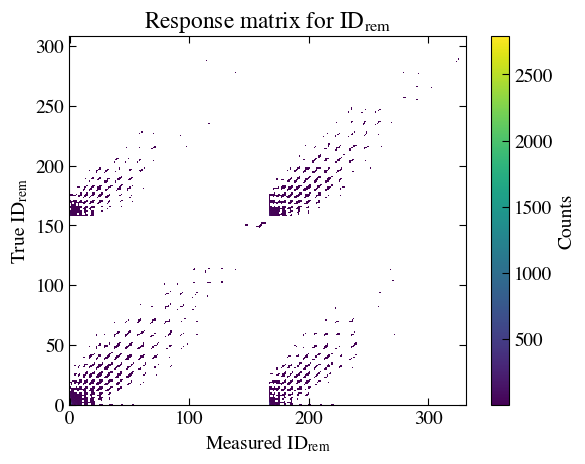

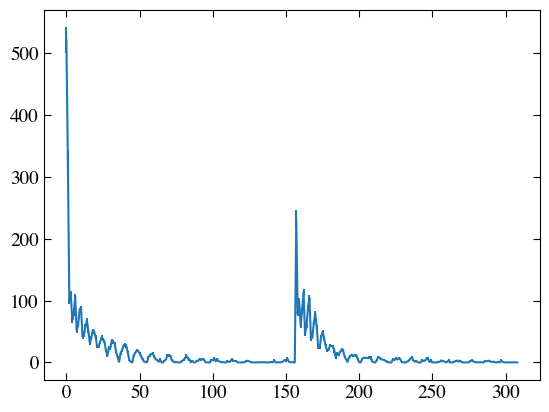

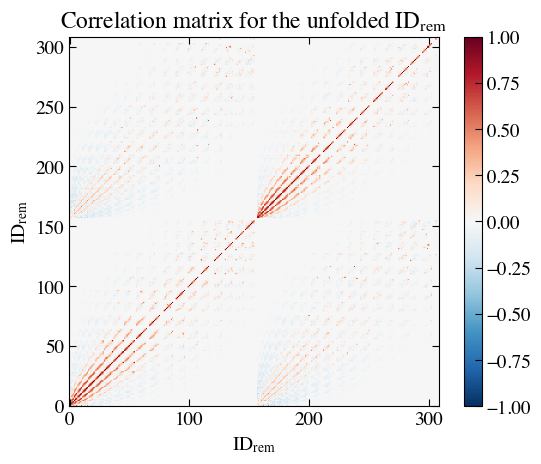

Now unfolding...
Iteration : 0
Chi^2 of change 8.85874
Iteration : 1
Chi^2 of change 4.71546
Iteration : 2
Chi^2 of change 3.17568
Iteration : 3
Chi^2 of change 2.3358
Calculating covariances due to number of measured events
Calculating covariances due to number of measured events


In [21]:
response = ROOT.RooUnfoldResponse(Nmeasbins_1D, 1, Nmeasbins_1D+1, Ntruebins_1D, 1, Ntruebins_1D+1) # 1D index starts from 1
for ievt in range(Nselected_true_evts):
    response.Fill(meas_3D1D_map[meas_SID3D[ievt]], true_3D1D_map[true_SID3D_sel[ievt]])
#rcanvas = ROOT.TCanvas() # draw response matrix
#response.Hresponse().Draw("colz")
#rcanvas.Draw()
response_matrix = np.zeros([Ntruebins_1D, Nmeasbins_1D])
for ibin in range(Ntruebins_1D):
    for jbin in range(Nmeasbins_1D):
        response_matrix[ibin, jbin] = response.Hresponse().GetBinContent(jbin+1, ibin+1)
#plt.figure(figsize=[15,15])
plt.imshow(np.ma.masked_where(response_matrix == 0, response_matrix), origin="lower")
plt.title(r"Response matrix for ${\rm ID_{rem}}$")
plt.xlabel(r"Measured ${\rm ID_{rem}}$")
plt.ylabel(r"True ${\rm ID_{rem}}$")
plt.colorbar(label="Counts")
plt.savefig("figs/response_matrix.pdf")
plt.show()

#tthtruth = []
#for ibin in range(Ntruebins_1D):
#    tthtruth.append(response.Htruth().GetBinContent(ibin+1))
#print("Htruth", tthtruth)
#tthmeasured = []
#for ibin in range(Nmeasbins_1D):
#    tthmeasured.append(response.Hmeasured().GetBinContent(ibin+1))
#print("Hmeasured", tthmeasured)

hMeas = ROOT.TH1D ("hmeas", "", Nmeasbins_1D, 0, Nmeasbins_1D)
for ibin in range(Nmeasbins_1D):
    hMeas.SetBinContent(ibin+1, data_meas_N1D[ibin])

uf = ROOT.RooUnfoldBayes(response, hMeas, niter=4) # niter should be optimized in further studies
data_meas_V1D_TM = ROOT.TMatrix(Nmeasbins_1D, Nmeasbins_1D)
for ibin in range(Nmeasbins_1D):
    for jbin in range(Nmeasbins_1D):
        data_meas_V1D_TM[ibin, jbin] = data_meas_V1D[ibin, jbin]
uf.SetMeasuredCov(data_meas_V1D_TM)

hUnfold = uf.Hunfold()
VUnfold = uf.Eunfold()

#canvas = ROOT.TCanvas()
#hUnfold.Draw()
#hMeas.Draw("SAME")
#hMeas.SetLineColor(8)
#canvas.Draw()
#VUnfold= uf.Eunfold()
#vcanvas = ROOT.TCanvas()
#VUnfold.Draw()
#vcanvas.Draw()

data_unfold = np.zeros(Ntruebins_1D)
data_unfold_cov = np.zeros([Ntruebins_1D, Ntruebins_1D])
for ibin in range(Ntruebins_1D):
    data_unfold[ibin] = hUnfold.GetBinContent(ibin+1)
    for jbin in range(Ntruebins_1D):
        data_unfold_cov[ibin, jbin] = VUnfold[ibin, jbin]
plt.errorbar(np.arange(0, Ntruebins_1D), data_unfold, np.sqrt(np.diag(data_unfold_cov)))
plt.show()
plt.imshow(transform_cov_to_corr_matrix(data_unfold_cov), origin="lower", cmap="RdBu_r", vmin=-1, vmax=1)
plt.title(r"Correlation matrix for the unfolded ${\rm ID_{rem}}$")
plt.xlabel(r"${\rm ID_{rem}}$")
plt.ylabel(r"${\rm ID_{rem}}$")
plt.colorbar()
plt.savefig("figs/corr_mat_meas_2.pdf")
plt.show()

### 1D Back to 3D

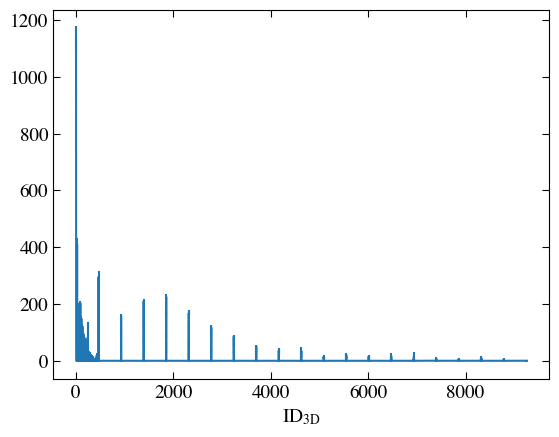

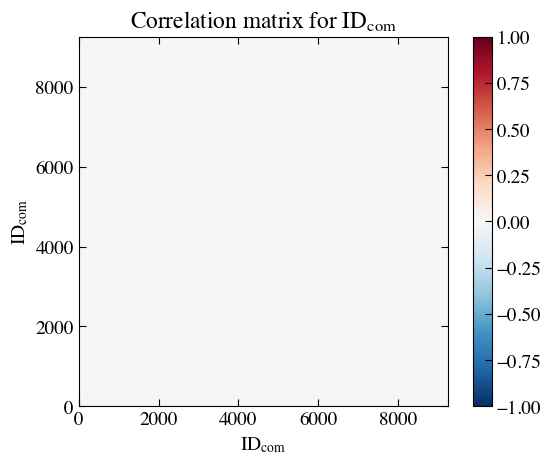

In [22]:
unfd_N3D = np.zeros(Ntruebins_3D)
unfd_N3D_Vcov = np.zeros([Ntruebins_3D, Ntruebins_3D])
for ibin in range(Ntruebins_3D):
    if true_3D1D_map[ibin] > 0:
        if data_unfold[true_3D1D_map[ibin]-1] > 0:
            unfd_N3D[ibin] = data_unfold[true_3D1D_map[ibin]-1] / eff1D[true_3D1D_map[ibin]-1]
            for jbin in range(Ntruebins_3D):
                if true_3D1D_map[jbin] > 0 and data_unfold[true_3D1D_map[jbin]-1] > 0:
                    unfd_N3D_Vcov[ibin, jbin] = data_unfold_cov[true_3D1D_map[ibin]-1, true_3D1D_map[jbin]-1] / (eff1D[true_3D1D_map[ibin]-1]*eff1D[true_3D1D_map[jbin]-1])
        elif eff1D[true_3D1D_map[ibin]-1] == 0:
            #print(data_unfold[true_3D1D_map[ibin]-1], true_N1D[true_3D1D_map[ibin]-1])
            unfd_N3D[ibin] = true_N3D[ibin]*data_MC_scale
            unfd_N3D_Vcov[ibin, ibin] = true_N3D_Vcov[ibin, ibin]*data_MC_scale*data_MC_scale
unfd_N3D_err = np.sqrt(np.diag(unfd_N3D_Vcov))

plt.errorbar(np.arange(0, Ntruebins_3D), unfd_N3D, unfd_N3D_err)
plt.xlabel(r"${\rm ID_{3D}}$")
plt.show()
plt.imshow(transform_cov_to_corr_matrix(unfd_N3D_Vcov), origin="lower", cmap="RdBu_r", vmin=-1, vmax=1)
plt.title(r"Correlation matrix for ${\rm ID_{com}}$")
plt.xlabel(r"${\rm ID_{com}}$")
plt.ylabel(r"${\rm ID_{com}}$")
plt.colorbar()
plt.savefig("figs/corr_mat_meas_3.pdf")#, dpi=4000)
plt.show()

### Error propagation to get the cross-section using unfolded histogram
We can use the same Jacobian matrices we derived above.

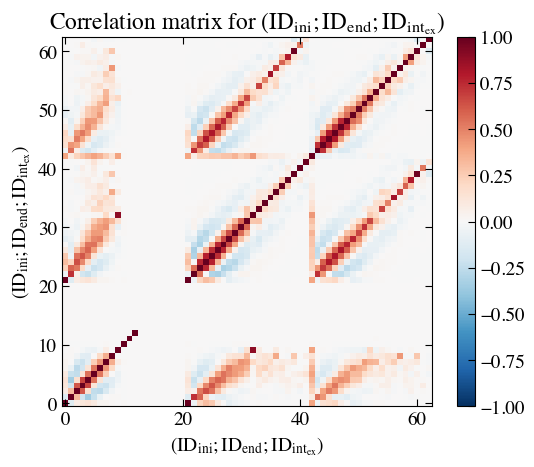

In [23]:
### derive the covariance matrix unfd_3SID_Vcov
#unfd_3SID_Vcov = np.einsum("ij,jk,lk->il", Jac_N3D_3SID, unfd_N3D_Vcov, Jac_N3D_3SID) # computation too slow
unfd_3SID_Vcov = np.einsum("ij,jk->ik", Jac_N3D_3SID, unfd_N3D_Vcov)
unfd_3SID_Vcov = np.einsum("ij,kj->ik", unfd_3SID_Vcov, Jac_N3D_3SID)

plt.imshow(transform_cov_to_corr_matrix(unfd_3SID_Vcov), origin="lower", cmap="RdBu_r", vmin=-1, vmax=1)
plt.title(r"Correlation matrix for $(\rm ID_{ini}; {\rm ID_{end}}; {\rm ID_{int_{ex}}})$")
plt.xlabel(r"$(\rm ID_{ini}; {\rm ID_{end}}; {\rm ID_{int_{ex}}})$")
plt.ylabel(r"$(\rm ID_{ini}; {\rm ID_{end}}; {\rm ID_{int_{ex}}})$")
plt.colorbar()
plt.savefig("figs/corr_mat_meas_4.pdf")
plt.show()

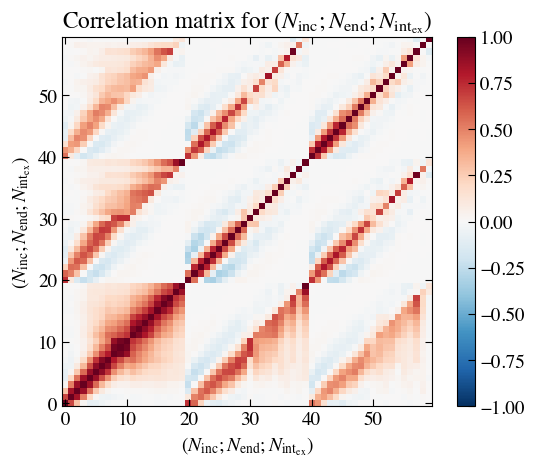

In [24]:
### derive the covariance matrix unfd_3N_Vcov
unfd_3N_Vcov = np.einsum("ij,jk,lk->il", Jac_3SID_3N, unfd_3SID_Vcov, Jac_3SID_3N)

plt.imshow(transform_cov_to_corr_matrix(unfd_3N_Vcov), origin="lower", cmap="RdBu_r", vmin=-1, vmax=1)
plt.title(r"Correlation matrix for $(N_{\rm inc}; N_{\rm end}; N_{\rm int_{ex}})$")
plt.xlabel(r"$(N_{\rm inc}; N_{\rm end}; N_{\rm int_{ex}})$")
plt.ylabel(r"$(N_{\rm inc}; N_{\rm end}; N_{\rm int_{ex}})$")
plt.colorbar()
plt.savefig("figs/corr_mat_meas_5.pdf")
plt.show()

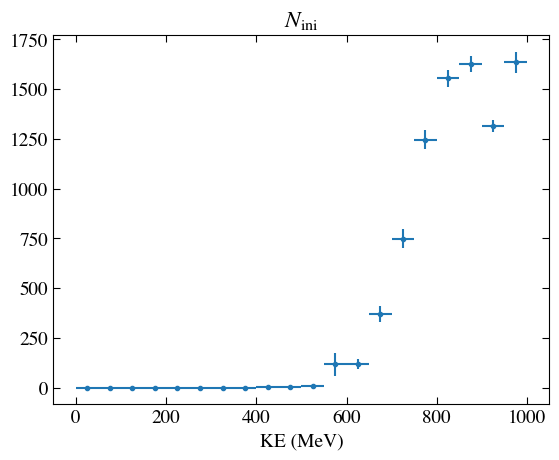

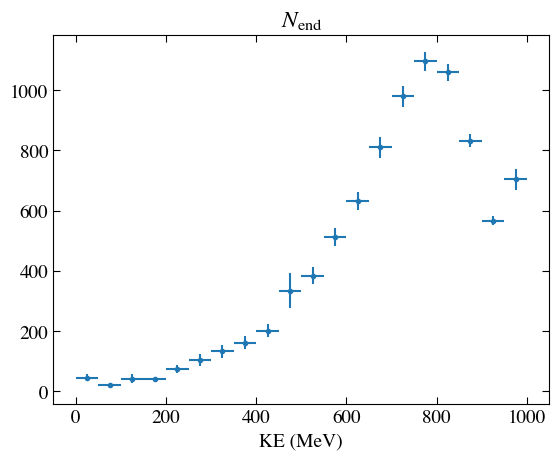

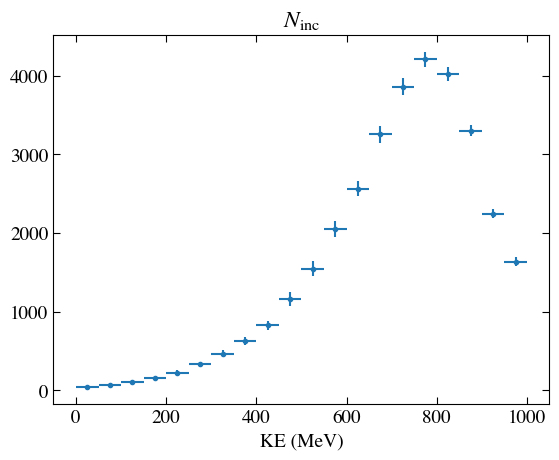

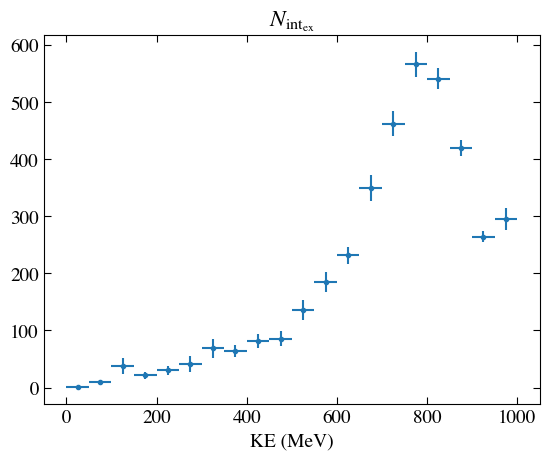

In [25]:
### get the histograms
unfd_N3D_real3D = np.reshape(unfd_N3D, [Ntruebins, Ntruebins, Ntruebins])
unfd_Nini = unfd_N3D_real3D.sum((0,1))[1:]
unfd_Nend = unfd_N3D_real3D.sum((0,2))[1:]
unfd_Nint_ex = unfd_N3D_real3D.sum((1,2))[1:]
unfd_Ninc = np.zeros_like(unfd_Nini)
for ibin in range(Ntruebins-1):
    ## two equivalent way to calculate the incident histogram
    for itmp in range(0, ibin+1):
        unfd_Ninc[ibin] += unfd_Nini[itmp]
    for itmp in range(0, ibin):
        unfd_Ninc[ibin] -= unfd_Nend[itmp]
    '''for itmp in range(ibin, Ntruebins-1):
        unfd_Ninc[ibin] += unfd_Nend[itmp]
    for itmp in range(ibin+1, Ntruebins-1):
        unfd_Ninc[ibin] -= unfd_Nini[itmp]'''

### get the uncertainty from the covariance matrix
unfd_Nini_err = np.sqrt(np.diagonal(unfd_3SID_Vcov)[1:Ntruebins])
unfd_Ninc_err = np.sqrt(np.diagonal(unfd_3N_Vcov)[:Ntruebins-1])
unfd_Nend_err = np.sqrt(np.diagonal(unfd_3N_Vcov)[Ntruebins-1:2*(Ntruebins-1)])
unfd_Nint_ex_err = np.sqrt(np.diagonal(unfd_3N_Vcov)[2*(Ntruebins-1):])

### plot the histograms related to the cross-section calculation with statistical uncertainty
plt.errorbar(true_cKE, unfd_Nini, unfd_Nini_err, true_wKE, ".")
plt.title(r"$N_{\rm ini}$")
plt.xlabel("KE (MeV)")
plt.show()
plt.errorbar(true_cKE, unfd_Nend, unfd_Nend_err, true_wKE, ".")
plt.title(r"$N_{\rm end}$")
plt.xlabel("KE (MeV)")
plt.show()
plt.errorbar(true_cKE, unfd_Ninc, unfd_Ninc_err, true_wKE, ".")
plt.title(r"$N_{\rm inc}$")
plt.xlabel("KE (MeV)")
plt.show()
plt.errorbar(true_cKE, unfd_Nint_ex, unfd_Nint_ex_err, true_wKE, ".")
plt.title(r"$N_{\rm int_{ex}}$")
plt.xlabel("KE (MeV)")
plt.show()

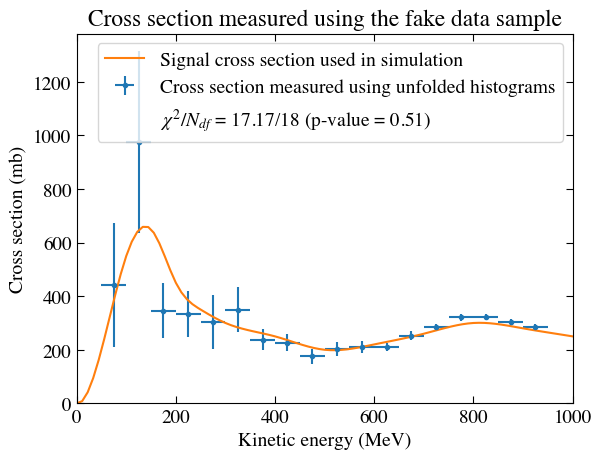

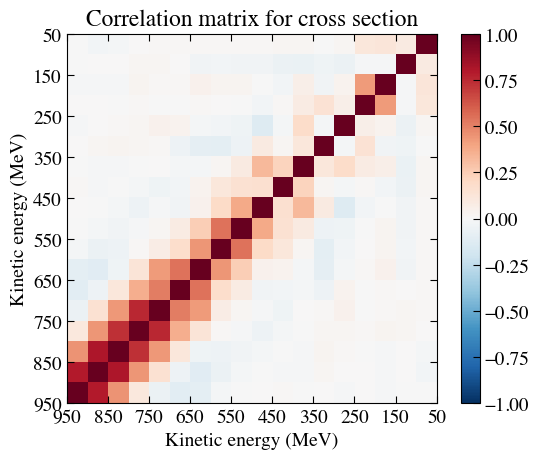

In [26]:
### get the signal cross-section extracted using the unfolded results with statistical uncertainty
unfd_XS = np.zeros_like(unfd_Nini)
Jac_3N_XS_unfd = np.zeros([Ntruebins-1, 3*(Ntruebins-1)]) # note here Jac_3N_XS_unfd is different with Jac_3N_XS_true
for ibin in range(Ntruebins-1):
    prefact = dEdx_mean(true_cKE[ibin]) / (n_tar*true_wKE[ibin]*2) * 1e27 # pre-factor
    Ninc = unfd_Ninc[ibin]
    Nend = unfd_Nend[ibin]
    Nint_ex = unfd_Nint_ex[ibin]
    
    if Nend == 0 or Ninc-Nend <= 0: # no track ends in this bin, or all tracks end in this bin
        unfd_XS[ibin] = 0
        Jac_3N_XS_unfd[ibin, ibin] = 0
        Jac_3N_XS_unfd[ibin, ibin+Ntruebins-1] = 0
        Jac_3N_XS_unfd[ibin, ibin+2*(Ntruebins-1)] = 0
    else:
        unfd_XS[ibin] = prefact * Nint_ex/Nend * np.log(Ninc/(Ninc-Nend))
        Jac_3N_XS_unfd[ibin, ibin] = prefact * Nint_ex / Ninc / (Nend-Ninc) # ∂σ/∂Ninc
        Jac_3N_XS_unfd[ibin, ibin+Ntruebins-1] = prefact * Nint_ex/Nend * (1/(Ninc-Nend) - 1/Nend*np.log(Ninc/(Ninc-Nend))) # ∂σ/∂Nend
        Jac_3N_XS_unfd[ibin, ibin+2*(Ntruebins-1)] = prefact * 1 / Nend *np.log(Ninc/(Ninc-Nend)) # ∂σ/∂Nint_ex

unfd_XS_Vcov = np.einsum("ij,jk,lk->il", Jac_3N_XS_unfd, unfd_3N_Vcov, Jac_3N_XS_unfd) # derive the covariance matrix unfd_XS_Vcov

### plot unfd_XS
XS_x = true_cKE[1:-1] # the underflow and overflow bin are not used
XS_y = unfd_XS[1:-1]
XS_xerr = true_wKE[1:-1]
XS_yerr = np.sqrt(np.diagonal(unfd_XS_Vcov)[1:-1]) # get the uncertainty from the covariance matrix
plt.errorbar(XS_x, XS_y, XS_yerr, XS_xerr, fmt=".", label="Cross section measured using unfolded histograms")
xx = np.linspace(0, 1100, 100)
plt.plot(xx,XS_gen_ex(xx), label="Signal cross section used in simulation")
plt.xlabel("Kinetic energy (MeV)")
plt.ylabel("Cross section (mb)") # 1 mb = 10^{-27} cm^2
plt.xlim([0,1000])
plt.ylim(bottom=0)
plt.title("Cross section measured using the fake data sample")

### calculate chi^2
XS_diff = XS_y - XS_gen_ex(XS_x)
inv_unfd_XS_Vcov = np.linalg.pinv(unfd_XS_Vcov[1:-1, 1:-1])
chi2 = np.einsum("i,ij,j->", XS_diff, inv_unfd_XS_Vcov, XS_diff)
#print(f"Chi2 ignoring correlations is {sum(XS_diff*XS_diff/np.diag(unfd_XS_Vcov)[1:-1]):.2f}/{len(XS_diff)}={sum(XS_diff*XS_diff/np.diag(unfd_XS_Vcov)[1:-1])/len(XS_diff):.2f}" )
plt.plot([], [], ' ', label=rf"$\chi^2/N_{{df}}$ = {chi2:.2f}/{len(XS_diff)} (p-value = {1-stats.chi2.cdf(chi2, len(XS_diff)):.2f})") # print chi2 result

handles, labels = plt.gca().get_legend_handles_labels()
order = [0,2,1]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
plt.savefig("figs/measXS.pdf")
plt.show()

plt.imshow(transform_cov_to_corr_matrix(unfd_XS_Vcov[1:-1, 1:-1]), origin="lower", cmap="RdBu_r", vmin=-1, vmax=1, extent=[950,50,950,50])
plt.title(r"Correlation matrix for cross section")
plt.xticks([950,850,750,650,550,450,350,250,150,50])
plt.yticks([950,850,750,650,550,450,350,250,150,50])
plt.xlabel(r"Kinetic energy (MeV)")
plt.ylabel(r"Kinetic energy (MeV)")
plt.colorbar()
plt.savefig("figs/corr_mat_meas_6.pdf")
plt.show()

## Part -1. Back-ups

### References
§ Slicing method

Section 3 in ProtoDUNE_Analysis_Note (email me yinrui@uchicago.edu for the link limited to DUNE members), or Section 2 in https://www.preprints.org/manuscript/202306.0560/v1 (rather outdated)

§ Error propagation

Appendix E in ProtoDUNE_Analysis_Note

### To-do's
§ Simulate measuring effects and implement unfolding

### Back-ups

§ Using a large true MC sample (300k events), we perform measurement on toys of size 1/100, and get the distribution of chi2 of measured XS.

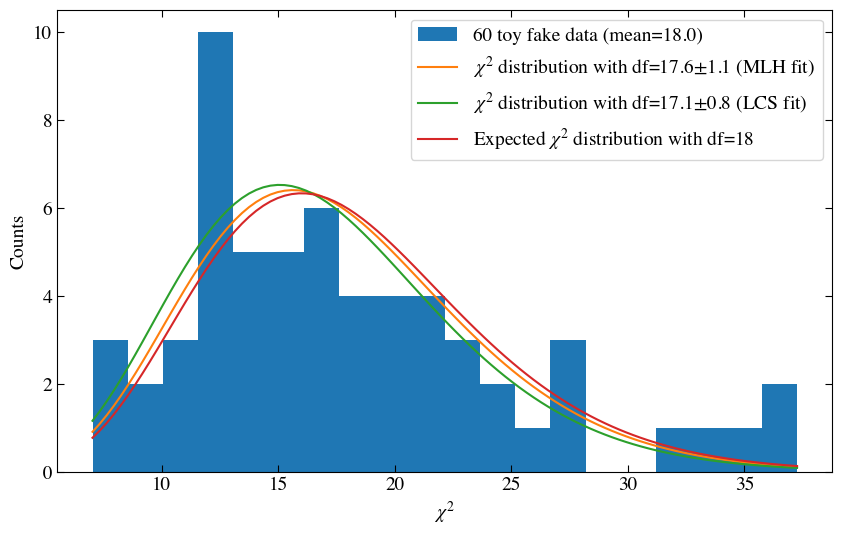

In [27]:
### meas 20 iter
chi2 = len(XS_diff)*np.array([0.87,1.28,2.07,0.97,1.15,0.43,0.41,0.55,0.66,1.12,2.03,0.74,1.93,0.75,0.89,0.56,0.81,0.66,1.27,0.93,0.48,0.92,0.96,0.84,0.67,1.49,0.66,0.68,1.04,1.37,0.62,0.39,1.02,1.85,0.97,0.81,1.07,0.71,0.77,1.04,1.03,1.17,0.67,1.51,0.73,0.71,1.12,0.63,1.52,0.73,1.42,0.70,1.21,1.38,1.20,1.80,1.26,0.91,0.66,1.09,])

plt.figure(figsize=[10,6])
bb, ed, _ = plt.hist(chi2,bins=20,label=f"{len(chi2)} toy fake data (mean={np.mean(chi2):.1f})")
norm_fact = (ed[1]-ed[0])*len(chi2)
xxx = np.linspace(min(chi2), max(chi2), 100)

def chi2pdf(x, df, loc=0, scale=1, con=1):
    return con*stats.chi2.pdf(x, df=df, loc=0, scale=scale)
def fitChi2Hist(data, pdf, **kwargs): 
    data = np.array(data)
    def nll(df):
        return -np.sum(np.log(pdf(data, df, **kwargs)))
    m = Minuit(nll, df=len(XS_diff))
    m.migrad()
    m.hesse()
    return m
mMLH = fitChi2Hist(chi2, chi2pdf, con=norm_fact)

cLCS = cost.LeastSquares((ed[1:]+ed[:-1])/2, bb, np.maximum(np.sqrt(bb),1), chi2pdf)
mLCS = Minuit(cLCS, df=len(XS_diff), loc=0, scale=1, con=norm_fact)
mLCS.fixed["loc", "scale", "con"] = True
mLCS.migrad()
mLCS.hesse()

plt.xlabel(r"$\chi^2$", fontsize=14)
plt.ylabel("Counts", fontsize=14)
yyy = chi2pdf(xxx, df=mMLH.values["df"], con=norm_fact)
plt.plot(xxx, yyy, label=rf"$\chi^2$ distribution with df={mMLH.values['df']:.1f}$\pm${mMLH.errors['df']:.1f} (MLH fit)")
yyy = chi2pdf(xxx, df=mLCS.values["df"], con=norm_fact)
plt.plot(xxx, yyy, label=rf"$\chi^2$ distribution with df={mLCS.values['df']:.1f}$\pm${mLCS.errors['df']:.1f} (LCS fit)")
plt.plot(xxx, chi2pdf(xxx, df=len(XS_diff), con=norm_fact), label=rf"Expected $\chi^2$ distribution with df={len(XS_diff)}")
plt.legend(fontsize=14)
plt.show()

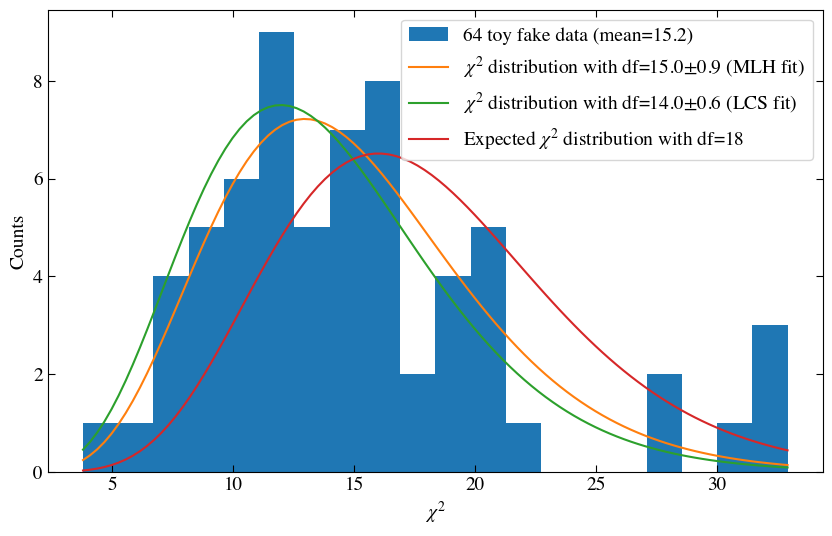

In [28]:
### meas 4 iter
chi2 = len(XS_diff)*np.array([0.62,0.79,1.22,0.68,0.64,0.53,1.54,0.91,1.15,1.14,1.09,0.77,0.53,0.53,0.66,0.86,0.54,1.05,0.92,0.77,0.92,1.17,0.45,0.84,0.99,0.87,0.75,0.59,0.69,1.58,0.47,0.62,0.67,0.39,1.14,0.50,1.10,0.83,0.21,0.34,0.81,0.86,0.60,0.82,0.71,0.67,0.55,0.86,1.83,1.82,1.13,0.83,0.63,0.80,0.58,0.39,0.76,0.39,0.90,1.69,1.81,1.00,1.05,0.59])

plt.figure(figsize=[10,6])
bb, ed, _ = plt.hist(chi2,bins=20,label=f"{len(chi2)} toy fake data (mean={np.mean(chi2):.1f})")
norm_fact = (ed[1]-ed[0])*len(chi2)
xxx = np.linspace(min(chi2), max(chi2), 100)

def chi2pdf(x, df, loc=0, scale=1, con=1):
    return con*stats.chi2.pdf(x, df=df, loc=0, scale=scale)
def fitChi2Hist(data, pdf, **kwargs): 
    data = np.array(data)
    def nll(df):
        return -np.sum(np.log(pdf(data, df, **kwargs)))
    m = Minuit(nll, df=len(XS_diff))
    m.migrad()
    m.hesse()
    return m
mMLH = fitChi2Hist(chi2, chi2pdf, con=norm_fact)

cLCS = cost.LeastSquares((ed[1:]+ed[:-1])/2, bb, np.maximum(np.sqrt(bb),1), chi2pdf)
mLCS = Minuit(cLCS, df=len(XS_diff), loc=0, scale=1, con=norm_fact)
mLCS.fixed["loc", "scale", "con"] = True
mLCS.migrad()
mLCS.hesse()

plt.xlabel(r"$\chi^2$", fontsize=14)
plt.ylabel("Counts", fontsize=14)
yyy = chi2pdf(xxx, df=mMLH.values["df"], con=norm_fact)
plt.plot(xxx, yyy, label=rf"$\chi^2$ distribution with df={mMLH.values['df']:.1f}$\pm${mMLH.errors['df']:.1f} (MLH fit)")
yyy = chi2pdf(xxx, df=mLCS.values["df"], con=norm_fact)
plt.plot(xxx, yyy, label=rf"$\chi^2$ distribution with df={mLCS.values['df']:.1f}$\pm${mLCS.errors['df']:.1f} (LCS fit)")
plt.plot(xxx, chi2pdf(xxx, df=len(XS_diff), con=norm_fact), label=rf"Expected $\chi^2$ distribution with df={len(XS_diff)}")
plt.legend(fontsize=14)
plt.show()

§ 100 toys are generated, each time with nevts==1000 and xstep=0.1, to see the distribution of chi2 of true XS.

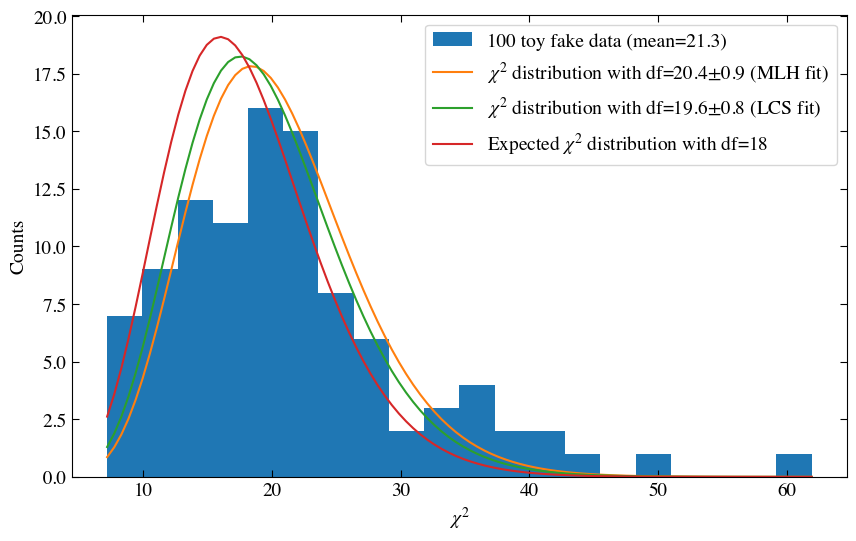

In [29]:
### true
chi2 = len(XS_diff)*np.array([1.39, 1.15, 0.9, 1.08, 1.82, 2.22, 0.58, 1.33, 0.84, 1.2, 1.03, 1.63, 1.47, 1.15, 0.85, 1.18, 0.83, 1.54, 1.17, 1.03, 1.95, 2.32, 0.43, 0.91, 0.94, 0.91, 0.84, 0.73, 0.51, 2.69, 1.19, 1.26, 1.86, 1.68, 1.37, 0.79, 1.60, 1.03, 0.42, 0.71, 1.29, 1.02, 0.83, 1.21, 1.30, 2.46, 0.73, 0.89, 1.86, 1.02, 0.55, 0.87, 1.04, 1.23, 1.42, 1.46, 0.64, 1.41, 1.08, 2.03, 0.64, 0.86, 2.32, 2.01, 0.60, 0.86, 0.88, 0.87, 0.46, 1.48, 1.10, 1.12, 0.62, 1.23, 0.82, 1.97, 1.01, 1.35, 0.40, 0.80, 1.33, 1.25, 1.05, 2.16, 1.31, 0.69, 0.73, 3.44, 0.62, 1.22, 0.65, 1.08, 0.52, 1.18, 0.64, 0.86, 1.57, 1.01, 1.21, 1.59])

plt.figure(figsize=[10,6])
bb, ed, _ = plt.hist(chi2,bins=20,label=f"{len(chi2)} toy fake data (mean={np.mean(chi2):.1f})")
norm_fact = (ed[1]-ed[0])*len(chi2)
xxx = np.linspace(min(chi2), max(chi2), 100)

def chi2pdf(x, df, loc=0, scale=1, con=1):
    return con*stats.chi2.pdf(x, df=df, loc=0, scale=scale)
def fitChi2Hist(data, pdf, **kwargs): 
    data = np.array(data)
    def nll(df):
        return -np.sum(np.log(pdf(data, df, **kwargs)))
    m = Minuit(nll, df=len(XS_diff))
    m.migrad()
    m.hesse()
    return m
mMLH = fitChi2Hist(chi2, chi2pdf, con=norm_fact)

cLCS = cost.LeastSquares((ed[1:]+ed[:-1])/2, bb, np.maximum(np.sqrt(bb),1), chi2pdf)
mLCS = Minuit(cLCS, df=len(XS_diff), loc=0, scale=1, con=norm_fact)
mLCS.fixed["loc", "scale", "con"] = True
mLCS.migrad()
mLCS.hesse()

plt.xlabel(r"$\chi^2$", fontsize=14)
plt.ylabel("Counts", fontsize=14)
yyy = chi2pdf(xxx, df=mMLH.values["df"], con=norm_fact)
plt.plot(xxx, yyy, label=rf"$\chi^2$ distribution with df={mMLH.values['df']:.1f}$\pm${mMLH.errors['df']:.1f} (MLH fit)")
yyy = chi2pdf(xxx, df=mLCS.values["df"], con=norm_fact)
plt.plot(xxx, yyy, label=rf"$\chi^2$ distribution with df={mLCS.values['df']:.1f}$\pm${mLCS.errors['df']:.1f} (LCS fit)")
plt.plot(xxx, chi2pdf(xxx, df=len(XS_diff), con=norm_fact), label=rf"Expected $\chi^2$ distribution with df={len(XS_diff)}")
plt.legend(fontsize=14)
plt.show()

In [30]:
#savetoyxs1 = pickle.load( open( "toy100_evt1w_stepsize01.p", "rb" ) )
#savetoyxs2 = pickle.load( open( "toy200_evt1w_stepsize01.p", "rb" ) )
#savetoyxs3 = pickle.load( open( "toy1_evt1w_stepsize01.p", "rb" ) )
#savetoyxs = {}
#savetoyxs["XS_true"] = np.concatenate([savetoyxs1["XS_true"], savetoyxs2["XS_true"], savetoyxs3["XS_true"]])
#savetoyxs["XS_iter2"] = np.concatenate([savetoyxs1["XS_iter2"], savetoyxs2["XS_iter2"], savetoyxs3["XS_iter2"]])
#savetoyxs["XS_iter4"] = np.concatenate([savetoyxs1["XS_iter4"], savetoyxs2["XS_iter4"], savetoyxs3["XS_iter4"]])
#savetoyxs["XS_iter10"] = np.concatenate([savetoyxs1["XS_iter10"], savetoyxs2["XS_iter10"], savetoyxs3["XS_iter10"]])
#savetoyxs["XScov_true"] = np.concatenate([savetoyxs1["XScov_true"], savetoyxs2["XScov_true"], savetoyxs3["XScov_true"]])
#savetoyxs["XScov_iter2"] = np.concatenate([savetoyxs1["XScov_iter2"], savetoyxs2["XScov_iter2"], savetoyxs3["XScov_iter2"]])
#savetoyxs["XScov_iter4"] = np.concatenate([savetoyxs1["XScov_iter4"], savetoyxs2["XScov_iter4"], savetoyxs3["XScov_iter4"]])
#savetoyxs["XScov_iter10"] = np.concatenate([savetoyxs1["XScov_iter10"], savetoyxs2["XScov_iter10"], savetoyxs3["XScov_iter10"]])
#XS_true = savetoyxs["XS_true"]
#XScov_true = savetoyxs["XScov_true"]
#XS_iter2 = savetoyxs["XS_iter2"]
#XScov_iter2 = savetoyxs["XScov_iter2"]
#XS_iter4 = savetoyxs["XS_iter4"]
#XScov_iter4 = savetoyxs["XScov_iter4"]
#XS_iter10 = savetoyxs["XS_iter10"]
#XScov_iter10 = savetoyxs["XScov_iter10"]
#pickle.dump( savetoyxs, open( "toy400_evt1w_stepsize01.p", "wb" ) )
savetoyxs = pickle.load( open( "toy1_evt1w_stepsize01.p", "rb" ) )
XS_true = savetoyxs["XS_true"]
XScov_true = savetoyxs["XScov_true"]
XS_iter2 = savetoyxs["XS_iter2"]
XScov_iter2 = savetoyxs["XScov_iter2"]
XS_iter4 = savetoyxs["XS_iter4"]
XScov_iter4 = savetoyxs["XScov_iter4"]
XS_iter10 = savetoyxs["XS_iter10"]
XScov_iter10 = savetoyxs["XScov_iter10"]


[-0.07760864143683002, 0.25903547407187294, 0.030515312915850277, -0.17476086091001813, 0.3783240349460401, 0.18130107154344421, 0.03133107913955334, 0.0037588966434685157, -0.1472627642025278, -0.09117624527731613, -0.338602784267472, -0.4549055139222494, -0.47232787563936535, -0.5098332709982872, -0.5274114990949252, -0.42801488617046524, -0.11265138096861373, 0.10584006305395184]
[1.0110564010856797, 0.9222511186999692, 1.0222982072742093, 0.9126518385577197, 0.9638298370635466, 1.0032817447156812, 1.095326965300226, 1.1124182431847975, 0.9829754954478461, 1.401737881448501, 1.2758866977755101, 1.2556830192246011, 1.3696995484009646, 1.200027057443165, 1.1054486394072036, 1.2920807950046147, 1.078399251111547, 1.0842819822016136]
0.10584006305395184 1.0842819822016136


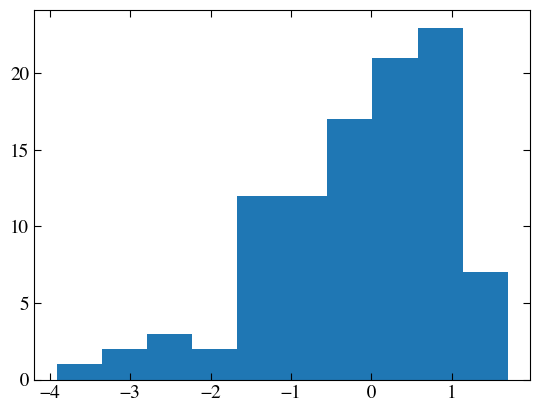

In [31]:
true_bins = np.array([1000,950,900,850,800,750,700,650,600,550,500,450,400,350,300,250,200,150,100,50,0])
true_cKE = (true_bins[:-1] + true_bins[1:])/2 # energy bin centers
XS_test = XS_iter4
XScov_test = XScov_iter4
XSmean_test = np.mean(XS_test, axis=0)
#print(XSmean_test.tolist())
def cal_chi2(XS_true, XS_y, unfd_XS_Vcov):
    XS_diff = XS_y - XS_true
    inv_unfd_XS_Vcov = np.linalg.pinv(unfd_XS_Vcov)
    chi2 = np.einsum("i,ij,j->", XS_diff, inv_unfd_XS_Vcov, XS_diff)
    return chi2
chi2_test = []
pull_test = []
for ii in range(len(XS_test)):
    xs = np.array(XS_test[ii])
    xscov = np.array(XScov_test[ii])
    chi2_test.append(cal_chi2(XS_gen_ex(true_cKE[1:-1]), xs, xscov))
    pull = (xs - XS_gen_ex(true_cKE[1:-1]))/np.sqrt(np.diag(xscov))
    #chi2_test.append(cal_chi2(XSmean_test, xs, xscov))
    #pull = (xs - XSmean_test)/np.sqrt(np.diag(xscov))
    pull_test.append(pull)
pull_test = np.array(pull_test)

def gauspdf(x, mu=0, sigma=1, con=1):
    return con*stats.norm.pdf(x, loc=mu, scale=sigma)
mmu = []
ssigma = []
mmu_err = []
ssigma_err = []
for ibin in range(len(pull_test[0])):
    pull = pull_test[:,ibin]
    bb, ed = np.histogram(pull)
    norm_fact = (ed[1]-ed[0])*len(pull)
    cLCS = cost.LeastSquares((ed[1:]+ed[:-1])/2, bb, np.maximum(np.sqrt(bb),1), gauspdf)
    mLCS = Minuit(cLCS, mu=0, sigma=1, con=norm_fact)
    mLCS.fixed["con"] = True
    mLCS.migrad()
    mLCS.hesse()
    mmu.append(mLCS.values['mu'])
    ssigma.append(mLCS.values['sigma'])
    mmu_err.append(mLCS.errors['mu'])
    ssigma_err.append(mLCS.errors['sigma'])
print(mmu)
print(ssigma)
ibin=17
plt.hist(pull_test[:,ibin])
print(mmu[ibin], ssigma[ibin])

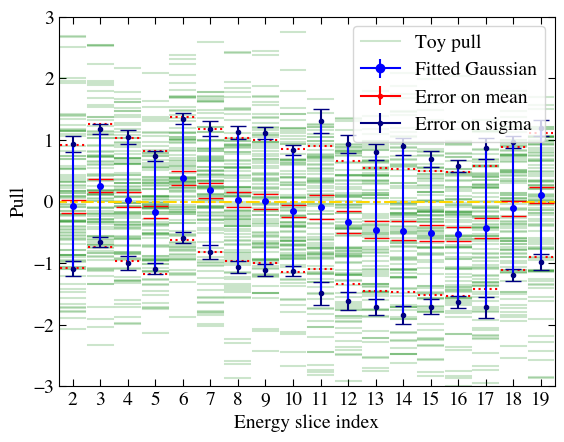

In [32]:
#plt.figure(figsize=[12,9])
for ibin in range(len(pull_test[0])):
    for ievt in range(len(pull_test)):
        plt.plot([ibin+1.55,ibin+2.45], [pull_test[ievt,ibin]]*2, "g-", alpha=0.2)
    plt.plot([ibin+1.5,ibin+2.5],[0]*2,"gold",linestyle='dashed')
    plt.plot([ibin+1.55,ibin+2.45],[mmu[ibin]-1]*2,"r",linestyle='dotted')
    plt.plot([ibin+1.55,ibin+2.45],[mmu[ibin]+1]*2,"r",linestyle='dotted')
    plt.errorbar(ibin+2, mmu[ibin], yerr=mmu_err[ibin], color="r", marker=".", capsize=9)
    plt.errorbar(ibin+2, mmu[ibin]+ssigma[ibin], yerr=ssigma_err[ibin], color="navy", marker=".", capsize=6)
    plt.errorbar(ibin+2, mmu[ibin]-ssigma[ibin], yerr=ssigma_err[ibin], color="navy", marker=".", capsize=6)
    plt.errorbar(ibin+2, mmu[ibin], yerr=ssigma[ibin], color="blue", marker="o", markersize=4)
plt.plot([], [], "g-", alpha=0.2, label="Toy pull")
plt.errorbar([],[], [], color="blue", marker="o", label="Fitted Gaussian")
plt.errorbar([],[], [], color="r", marker=".", capsize=9, label="Error on mean")
plt.errorbar([],[], [], color="navy", marker=".", capsize=6, label="Error on sigma")
plt.xlim([1.5,len(pull_test[0])+1.5])
plt.ylim([-3,3])
plt.xticks(np.arange(2,20))
plt.xlabel("Energy slice index")
plt.ylabel("Pull")
plt.legend()
#plt.savefig("figs/toy_validation_pull_truemean.pdf")
plt.show()

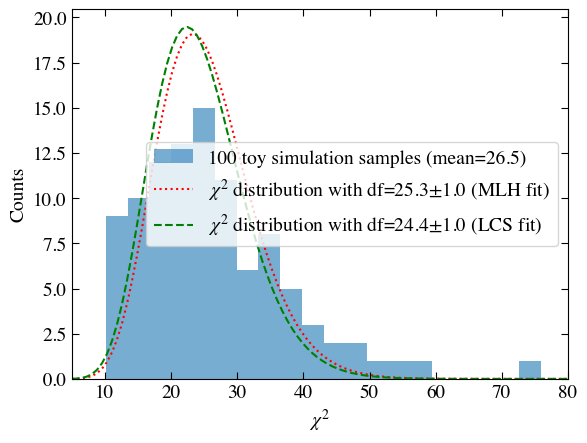

In [33]:
XS_diff = [1]*18
chi2 = np.array(chi2_test)
minchi2 = 5
maxchi2 = 80
chi2 = chi2[chi2>minchi2]
chi2 = chi2[chi2<maxchi2]
#plt.figure(figsize=[10,6])
bb, ed, _ = plt.hist(chi2,bins=20,alpha=0.6,label=f"{len(chi2)} toy simulation samples (mean={np.mean(chi2):.1f})")
norm_fact = (ed[1]-ed[0])*len(chi2)
xxx = np.linspace(minchi2, maxchi2, 100)

def chi2pdf(x, df, loc=0, scale=1, con=1):
    return con*stats.chi2.pdf(x, df=df, loc=0, scale=scale)
def fitChi2Hist(data, pdf, **kwargs): 
    data = np.array(data)
    def nll(df):
        return -np.sum(np.log(pdf(data, df, **kwargs)))
    m = Minuit(nll, df=len(XS_diff))
    m.migrad()
    m.hesse()
    return m
mMLH = fitChi2Hist(chi2, chi2pdf, con=norm_fact)

cLCS = cost.LeastSquares((ed[1:]+ed[:-1])/2, bb, np.maximum(np.sqrt(bb),1), chi2pdf)
mLCS = Minuit(cLCS, df=len(XS_diff), loc=0, scale=1, con=norm_fact)
mLCS.fixed["loc", "scale", "con"] = True
mLCS.migrad()
mLCS.hesse()

plt.xlabel(r"$\chi^2$")
plt.ylabel("Counts")
yyy = chi2pdf(xxx, df=mMLH.values["df"], con=norm_fact)
plt.plot(xxx, yyy, "r", linestyle="dotted", label=rf"$\chi^2$ distribution with df={mMLH.values['df']:.1f}$\pm${mMLH.errors['df']:.1f} (MLH fit)")
yyy = chi2pdf(xxx, df=mLCS.values["df"], con=norm_fact)
plt.plot(xxx, yyy, "g", linestyle="dashed", label=rf"$\chi^2$ distribution with df={mLCS.values['df']:.1f}$\pm${mLCS.errors['df']:.1f} (LCS fit)")
#plt.plot(xxx, chi2pdf(xxx, df=len(XS_diff), con=norm_fact), label=rf"Expected $\chi^2$ distribution with df={len(XS_diff)}")
plt.xlim([minchi2, maxchi2])
plt.legend()
#plt.savefig("figs/toy_validation_chi2_truemean.pdf")
plt.show()